In [2]:
!pip install --upgrade pip
!pip install lightgbm
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install hyperopt
!pip install \
    'dask>2023.3.2' \
    'distributed>2023.3.2'

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


ModuleNotFoundError: No module named 'seaborn'

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
curr_dir = os.path.abspath(os.getcwd())
data_dir = os.path.join(curr_dir,'Data')
model_dir = os.path.join(curr_dir,'Models')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
model_360_new = lightgbm.Booster(model_file = os.path.join(model_dir,'quantile_regression_360_0.5_days_2025-02-23.txt'))
model_360_old = lightgbm.Booster(model_file = os.path.join(model_dir,'quantile_regression_360+_0.5_days_2024-03-19.txt'))
df_oot_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_oot_validation_360_days.csv'))
# df_test_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_test_360_days.csv'))              

In [6]:
df_oot_360['cohort_age'].value_counts()

cohort_age
720    8321
630    1398
540    1393
450    1377
360    1358
Name: count, dtype: int64

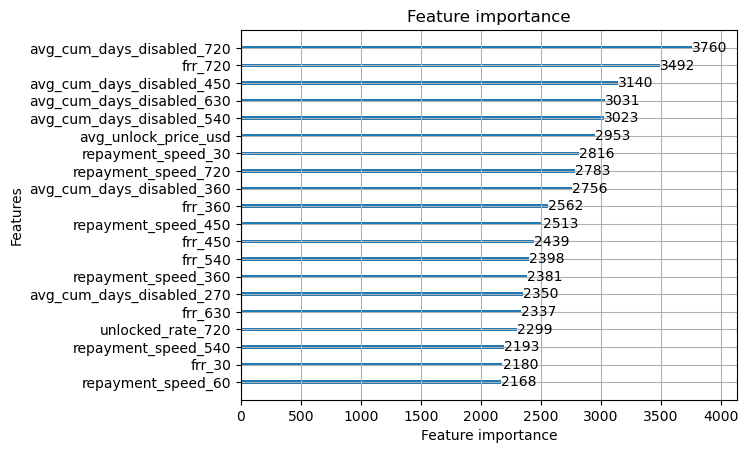

In [7]:
from lightgbm import LGBMRegressor, plot_importance
plot_importance(model_360_new, max_num_features=20)
plt.show()

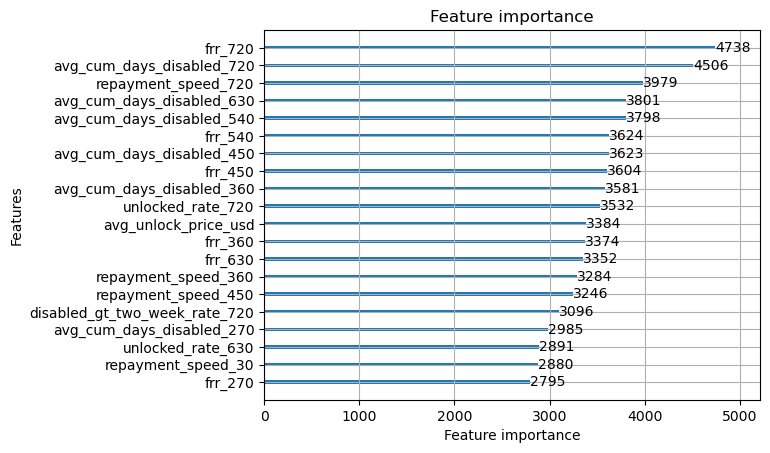

In [8]:
plot_importance(model_360_old, max_num_features=20)
plt.show()

In [9]:
df_oot_360_new = df_oot_360.copy()
df_oot_360_old = df_oot_360.copy()

In [10]:
df_oot_360

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age
0,2021-08_Kenya_SHS with TV Upgrade_Samburu_Sun ...,2,36.600980,581,0.048264,0.093690,0.145180,0.290360,0.429217,0.572364,0.701019,0.841883,0.969932,NaN,1.2045,1.0146,1.0040,0.9633,0.9367,0.9306,0.9083,0.9066,0.9699,NaN,0.0,2.0,4.0,9.0,18.0,26.0,42.0,51.0,58.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,NaN,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1418.104986,1418.104986,2021-08,Kenya,SHS with TV Upgrade,Samburu,Sun King Home 600 Mini EasyBuy,41,630
1,2021-09_Kenya_SHS Entry-Level_Tongareni_Sun Ki...,29,394.913184,367,0.100696,0.178780,0.235122,0.394470,0.543644,0.665062,0.738970,0.782028,0.822998,0.847211,1.4843,1.1436,0.9604,0.7730,0.7008,0.7095,0.7724,0.8011,0.8267,0.8472,3.0,11.0,18.0,50.0,85.0,120.0,157.0,194.0,219.0,244.0,0.178571,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.068966,0.103448,0.103448,0.137931,0.034483,0.137931,0.103448,0.034483,0.034483,0.034483,0.034483,0.068966,0.206897,0.379310,0.413793,0.482759,0.586207,0.241379,0.206897,0.241379,0.344828,0.413793,0.482759,0.448276,0.344828,0.344828,0.310345,0.897081,3023.462993,3370.334444,2021-09,Kenya,SHS Entry-Level,Tongareni,Sun King Home 60 EasyBuy,40,720
2,2021-09_Kenya_SHS with TV_Chwele_Sun King Home...,5,290.510853,637,0.039069,0.107165,0.132200,0.230955,0.293934,0.382979,0.453909,NaN,NaN,NaN,1.0701,1.2738,1.0034,0.8410,0.7041,0.6835,0.6455,NaN,NaN,NaN,1.0,6.0,16.0,41.0,72.0,112.0,156.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.400000,0.600000,0.400000,0.400000,0.600000,0.400000,0.800000,NaN,NaN,NaN,0.665297,1940.611845,2916.910560,2021-09,Kenya,SHS with TV,Chwele,Sun King Home 400 Easybuy GSM,40,450
3,2021-09_Tanzania_SHS Entry-Level_Makambako_Sun...,6,103.560996,371,0.052792,0.126559,0.188595,0.343778,0.500705,0.707232,0.748329,0.761323,0.765778,0.772832,0.8354,0.8691,0.8270,0.7233,0.6929,0.7292,0.7483,0.7613,0.7657,0.7728,4.0,8.0,13.0,32.0,48.0,64.0,69.0,77.0,89.0,103.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [11]:
df_oot_360['cohort_age'].value_counts()

cohort_age
720    8321
630    1398
540    1393
450    1377
360    1358
Name: count, dtype: int64

In [10]:
def feature_engineering(df_to_predict):
    
    df_to_predict['product_group'] = df_to_predict['product_group'].fillna('NA')
    # Creating column for Unlock price
    df_to_predict['unlock_price_usd'] = df_to_predict['upfront_price_usd'] + df_to_predict['total_follow_on_revenue_usd']
    
    # Calculating averge unlock and upfront price
    df_to_predict['avg_upfront_price_usd'] = np.round((df_to_predict['upfront_price_usd']/df_to_predict['count_units']),0)
    df_to_predict['avg_unlock_price_usd'] = np.round((df_to_predict['unlock_price_usd']/df_to_predict['count_units']),0)
    
    # Removing unnecessary columns
    #cols_to_remove = [col for col in df_to_predict.columns if ('repayment_speed_' in col)]
    cols_to_remove = []
    cols_to_remove.append('upfront_price_usd')
    cols_to_remove.append('unlock_price_usd')

    print('columns to remove: ',cols_to_remove)
    
    df_to_predict.drop(cols_to_remove, axis=1, inplace=True)
    
    return df_to_predict

In [11]:
feature_cols_5 = model_360_new.feature_name()
print(len(feature_cols_5))

73


In [12]:
model_360_new.feature_name()

['avg_planned_repayment_days',
 'frr_30',
 'frr_60',
 'frr_90',
 'frr_180',
 'frr_270',
 'frr_360',
 'frr_450',
 'frr_540',
 'frr_630',
 'frr_720',
 'repayment_speed_30',
 'repayment_speed_60',
 'repayment_speed_90',
 'repayment_speed_180',
 'repayment_speed_270',
 'repayment_speed_360',
 'repayment_speed_450',
 'repayment_speed_540',
 'repayment_speed_630',
 'repayment_speed_720',
 'avg_cum_days_disabled_30',
 'avg_cum_days_disabled_60',
 'avg_cum_days_disabled_90',
 'avg_cum_days_disabled_180',
 'avg_cum_days_disabled_270',
 'avg_cum_days_disabled_360',
 'avg_cum_days_disabled_450',
 'avg_cum_days_disabled_540',
 'avg_cum_days_disabled_630',
 'avg_cum_days_disabled_720',
 'at_risk_rate_30',
 'at_risk_rate_60',
 'at_risk_rate_90',
 'at_risk_rate_180',
 'at_risk_rate_270',
 'at_risk_rate_360',
 'at_risk_rate_450',
 'at_risk_rate_540',
 'at_risk_rate_630',
 'at_risk_rate_720',
 'disabled_gt_two_week_rate_30',
 'disabled_gt_two_week_rate_60',
 'disabled_gt_two_week_rate_90',
 'disabled_g

In [12]:
def prediction_on_data_new_model(backtesting_model, df_to_predict, model): 
    
    #df_to_predict = data[data['backtesting_limit'] == backtesting_model].reset_index().drop(columns = 'index')
    df = feature_engineering(df_to_predict)
    
    #model_1 = lightgbm.Booster(model_file = os.path.join(args.input_path ,dict_models[backtesting_model][0]))
    model_5 = model #lightgbm.Booster(model_file = os.path.join(args.input_path ,dict_models[backtesting_model][1]))
    #model_8 = lightgbm.Booster(model_file = os.path.join(args.input_path ,dict_models[backtesting_model][2]))

    #feature_cols_1 = model_1.feature_name()
    feature_cols_5 = model_5.feature_name()
    #feature_cols_8 = model_8.feature_name()

    X = df.drop(['accounts_group','count_units','total_follow_on_revenue_usd',
                        'reg_month','country','product_group','area','primary_product','age_in_months',
                'cohort_age','actual_fr'], axis=1)
    #X_1 = df[feature_cols_1]
    #X_5 = X.rename(columns = {'avg_upfront_price_usd':'avg_upfront_price', 'avg_unlock_price_usd':'avg_unlock_price'})
    X_5 = df[feature_cols_5]
    print(X_5.shape)
    #X_8 = df[feature_cols_8]
        
    #y_pred = model.predict(X)
    classifiers = {}
    #pred_1 = pd.DataFrame(model_1.predict(X_1), columns = [str(0.1)])
    pred_5 = pd.DataFrame(model_5.predict(X_5), columns = [str(0.5)])
    #pred_8 = pd.DataFrame(model_8.predict(X_8), columns = [str(0.8)])
    #classifiers[str(0.1)] = {'clf': model_1, 'predictions': pred_1}
    classifiers[str(0.5)] = {'clf': model_5, 'predictions': pred_5}
    #classifiers[str(0.8)] = {'clf': model_8, 'predictions': pred_8}

    pred_data = pd.DataFrame({'0.5': classifiers['0.5']['predictions']['0.5'],'days': backtesting_model})
    
    return pred_data

In [13]:
def fix_predictions(df_to_predict, y_pred_test):
    
    #df_to_predict['prediction_0.1'] = y_pred_test['0.1']
    df_to_predict['prediction_0.5'] = y_pred_test['0.5']
    #df_to_predict['prediction_0.8'] = y_pred_test['0.8']
    
    
    #df_to_predict.loc[df_to_predict['prediction_0.1']<0,'prediction_0.1'] =0
    #df_to_predict.loc[df_to_predict['prediction_0.1']>1,'prediction_0.1'] =1
    df_to_predict.loc[df_to_predict['prediction_0.5']<0,'prediction_0.5'] =0
    df_to_predict.loc[df_to_predict['prediction_0.5']>1,'prediction_0.5'] =1
    #df_to_predict.loc[df_to_predict['prediction_0.8']<0,'prediction_0.8'] =0
    #df_to_predict.loc[df_to_predict['prediction_0.8']>1,'prediction_0.8'] =1
    
    df_to_predict.loc[df_to_predict['frr_3_years']<0,'frr_3_years'] =0
    df_to_predict.loc[df_to_predict['frr_3_years']>1,'frr_3_years'] =1
    
    # Ensuring predicted FRR is never less than the last observed FRR
    
        
    df_to_predict.loc[(df_to_predict['age_in_months']==360) & (df_to_predict['frr_360']>df_to_predict['prediction_0.5']),'prediction_0.5'] = df_to_predict['frr_360']
    df_to_predict.loc[(df_to_predict['age_in_months']==450) & (df_to_predict['frr_450']>df_to_predict['prediction_0.5']),'prediction_0.5'] = df_to_predict['frr_450']
    df_to_predict.loc[(df_to_predict['age_in_months']==540) & (df_to_predict['frr_540']>df_to_predict['prediction_0.5']),'prediction_0.5'] = df_to_predict['frr_540']
    df_to_predict.loc[(df_to_predict['age_in_months']==630) & (df_to_predict['frr_630']>df_to_predict['prediction_0.5']),'prediction_0.5'] = df_to_predict['frr_630']
    df_to_predict.loc[(df_to_predict['age_in_months']==720) & (df_to_predict['frr_720']>df_to_predict['prediction_0.5']),'prediction_0.5'] = df_to_predict['frr_720']
    
    #df_to_predict['predicted_revenue_USD_0.1'] = np.round(df_to_predict['prediction_0.1']*df_to_predict['total_follow_on_revenue_current_usd'],2)
    df_to_predict['predicted_revenue_USD_0.5'] = np.round(df_to_predict['prediction_0.5']*df_to_predict['total_follow_on_revenue_usd'],2)
    #df_to_predict['predicted_revenue_USD_0.8'] = np.round(df_to_predict['prediction_0.8']*df_to_predict['total_follow_on_revenue_current_usd'],2)

    return df_to_predict

In [14]:
def new_model_predictions_pipeline(df_oot_360_new,model_360_new):
    
    pred_data = prediction_on_data_new_model(360, df_oot_360_new, model_360_new)
    df_to_predict_new = fix_predictions(df_oot_360_new, pred_data)
    
    df_to_predict_new.rename(columns={'prediction_0.5':'frr_prediction_50_new',
                                      'predicted_revenue_USD_0.5':'predicted_revenue_3_years_50_new'}, inplace=True)
    df_to_predict_new = df_to_predict_new[['accounts_group','frr_3_years', 'actual_fr', 'total_follow_on_revenue_usd', 'reg_month',
       'country', 'product_group', 'area', 'primary_product','frr_prediction_50_new', 'predicted_revenue_3_years_50_new']]
    return df_to_predict_new

In [15]:
def old_model_predictions_pipeline(df_oot_360_old,model_360_old):
    
    pred_data = prediction_on_data_new_model(360, df_oot_360_old, model_360_old)
    df_to_predict_old = fix_predictions(df_oot_360_old, pred_data)
    
    df_to_predict_old.rename(columns={'prediction_0.5':'frr_prediction_50_old',
                                      'predicted_revenue_USD_0.5':'predicted_revenue_3_years_50_old'}, inplace=True)
    df_to_predict_old = df_to_predict_old[['accounts_group','frr_3_years', 'actual_fr', 'total_follow_on_revenue_usd', 'reg_month',
       'country', 'product_group', 'area', 'primary_product','frr_prediction_50_old', 'predicted_revenue_3_years_50_old']]
    return df_to_predict_old

In [16]:
def actual_vs_predictions(df_to_predict_new, df_to_predict_old):
    
    df_to_predict_old = df_to_predict_old[['accounts_group','frr_prediction_50_old','predicted_revenue_3_years_50_old']].copy()
    df_final_pred = pd.merge(df_to_predict_new, df_to_predict_old, on='accounts_group', how='inner')
    df_final_pred['Error_new'] = np.abs(df_final_pred['frr_3_years'] - df_final_pred['frr_prediction_50_new'])
    df_final_pred['Error_old'] = np.abs(df_final_pred['frr_3_years'] - df_final_pred['frr_prediction_50_old'])
    
    # Calculate actual vs predicted revenue un USD
    #df_test['actual_revenue_3_years'] = df_test['frr_3_years']* df_test['total_follow_on_revenue_usd']
    df_final_pred['predicted_revenue_3_years_new'] = df_final_pred['frr_prediction_50_new']* df_final_pred['total_follow_on_revenue_usd']
    df_final_pred['predicted_revenue_3_years_old'] = df_final_pred['frr_prediction_50_old']* df_final_pred['total_follow_on_revenue_usd']
    
    
    #total_revenue_actual = np.round(df_test['actual_revenue_3_years'].sum())
    #print('Revenue realized actual: {0}'.format(total_revenue_actual))
    total_revenue_predicted_new = np.round(df_final_pred['predicted_revenue_3_years_new'].sum())
    print('Revenue realized predicted new: {0}'.format(total_revenue_predicted_new))
    total_revenue_predicted_old = np.round(df_final_pred['predicted_revenue_3_years_old'].sum())
    print('Revenue realized predicted old: {0}'.format(total_revenue_predicted_old))
    
    total_follow_on_revenue = np.round(df_final_pred['total_follow_on_revenue_usd'].sum())
    print('Total Follow-on Revenue: {0}'.format(total_follow_on_revenue))
    
    #actual_FRR = np.round(total_revenue_actual/total_follow_on_revenue,4)
    predicted_FRR_new = np.round(total_revenue_predicted_new/total_follow_on_revenue,4)
    predicted_FRR_old = np.round(total_revenue_predicted_old/total_follow_on_revenue,4)

    #print('Actual FRR at 3 years: {0}'.format(actual_FRR))
    print('Predicted FRR at 3 years new: {0}'.format(predicted_FRR_new))
    print('Predicted FRR at 3 years old: {0}'.format(predicted_FRR_old))
    
    return df_final_pred, predicted_FRR_new, predicted_FRR_old

In [17]:
df_to_predict_new = new_model_predictions_pipeline(df_oot_360_new,model_360_new)
df_to_predict_old = old_model_predictions_pipeline(df_oot_360_old,model_360_old)

columns to remove:  ['upfront_price_usd', 'unlock_price_usd']
(13847, 73)
columns to remove:  ['upfront_price_usd', 'unlock_price_usd']
(13847, 73)


In [18]:
df_to_predict_new

,accounts_group,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,primary_product,frr_prediction_50_new,predicted_revenue_3_years_50_new
0,2021-08_Kenya_SHS with TV Upgrade_Samburu_Sun ...,1.000000,1418.104986,1418.104986,2021-08,Kenya,SHS with TV Upgrade,Samburu,Sun King Home 600 Mini EasyBuy,1.000000,1418.10
1,2021-09_Kenya_SHS Entry-Level_Tongareni_Sun Ki...,0.897081,3023.462993,3370.334444,2021-09,Kenya,SHS Entry-Level,Tongareni,Sun King Home 60 EasyBuy,0.900541,3035.13
2,2021-09_Kenya_SHS with TV_Chwele_Sun King Home...,0.665297,1940.611845,2916.910560,2021-09,Kenya,SHS with TV,Chwele,Sun King Home 400 Easybuy GSM,0.815010,2377.31
3,2021-09_Tanzania_SHS Entry-Level_Makambako_Sun...,0.788721,916.730130,1162.299634,2021-09,Tanzania,SHS Entry-Level,Makambako,Sun King Home 120 EasyBuy,0.799431,929.18
4,2021-09_Kenya_SHS with TV Upgrade_Mumias_Sun K...,0.844579,6279.666326,7435.262215,2021-09,Kenya,SHS with TV Upgrade,Mumias,Sun King Home 600 Easybuy GSM,0.887514,6598.90
...,...,...,...,...,...,...,...,...,...,...,...
13842,2021-09_Kenya_Lanterns_Eldama Ravine_Sun King ...,0.934043,16893.210266,18086.116234,2021-09,Kenya,Lanterns,Eldama Ravine,Sun King Boom EasyBuy,0.931121,16840.36
13843,2022-01_Tanzania_SHS with TV Upgrade_Karatu_Su...,0.332933,360.606248,1083.119572,2022-01,Tanzania,SHS with TV Upgrade,Karatu,Sun King Home 400 Easybuy GSM,0.364906,395.24
13844,2022-01_Kenya_SHS Entry-Level_Nandi_Sun King H...,0.680820,453.869996,666.651972,2022-01,Kenya,SHS Entry-Level,Nandi,Sun King Home 120 EasyBuy,0.731540,487.68
13845,2022-01_Kenya_SHS Entry-Level_Port Victoria_Su...,0.806548,1613.060444,1999.955916,2022-01,Kenya,SHS Entry-Level,Port Victoria,Sun King Home 120 Plus EasyBuy,0.815394,1630.75


In [19]:
df_to_predict_old

,accounts_group,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,primary_product,frr_prediction_50_old,predicted_revenue_3_years_50_old
0,2021-08_Kenya_SHS with TV Upgrade_Samburu_Sun ...,1.000000,1418.104986,1418.104986,2021-08,Kenya,SHS with TV Upgrade,Samburu,Sun King Home 600 Mini EasyBuy,0.986545,1399.02
1,2021-09_Kenya_SHS Entry-Level_Tongareni_Sun Ki...,0.897081,3023.462993,3370.334444,2021-09,Kenya,SHS Entry-Level,Tongareni,Sun King Home 60 EasyBuy,0.904944,3049.96
2,2021-09_Kenya_SHS with TV_Chwele_Sun King Home...,0.665297,1940.611845,2916.910560,2021-09,Kenya,SHS with TV,Chwele,Sun King Home 400 Easybuy GSM,0.790131,2304.74
3,2021-09_Tanzania_SHS Entry-Level_Makambako_Sun...,0.788721,916.730130,1162.299634,2021-09,Tanzania,SHS Entry-Level,Makambako,Sun King Home 120 EasyBuy,0.801522,931.61
4,2021-09_Kenya_SHS with TV Upgrade_Mumias_Sun K...,0.844579,6279.666326,7435.262215,2021-09,Kenya,SHS with TV Upgrade,Mumias,Sun King Home 600 Easybuy GSM,0.877455,6524.11
...,...,...,...,...,...,...,...,...,...,...,...
13842,2021-09_Kenya_Lanterns_Eldama Ravine_Sun King ...,0.934043,16893.210266,18086.116234,2021-09,Kenya,Lanterns,Eldama Ravine,Sun King Boom EasyBuy,0.921314,16662.98
13843,2022-01_Tanzania_SHS with TV Upgrade_Karatu_Su...,0.332933,360.606248,1083.119572,2022-01,Tanzania,SHS with TV Upgrade,Karatu,Sun King Home 400 Easybuy GSM,0.383906,415.82
13844,2022-01_Kenya_SHS Entry-Level_Nandi_Sun King H...,0.680820,453.869996,666.651972,2022-01,Kenya,SHS Entry-Level,Nandi,Sun King Home 120 EasyBuy,0.722099,481.39
13845,2022-01_Kenya_SHS Entry-Level_Port Victoria_Su...,0.806548,1613.060444,1999.955916,2022-01,Kenya,SHS Entry-Level,Port Victoria,Sun King Home 120 Plus EasyBuy,0.809492,1618.95


In [20]:
df_final_pred, predicted_FRR_new, predicted_FRR_old = actual_vs_predictions(df_to_predict_new, df_to_predict_old)

Revenue realized predicted new: 59575647.0
Revenue realized predicted old: 59385937.0
Total Follow-on Revenue: 67341821.0
Predicted FRR at 3 years new: 0.8847
Predicted FRR at 3 years old: 0.8819


In [21]:
df_final_pred

,accounts_group,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,primary_product,frr_prediction_50_new,predicted_revenue_3_years_50_new,frr_prediction_50_old,predicted_revenue_3_years_50_old,Error_new,Error_old,predicted_revenue_3_years_new,predicted_revenue_3_years_old
0,2021-08_Kenya_SHS with TV Upgrade_Samburu_Sun ...,1.000000,1418.104986,1418.104986,2021-08,Kenya,SHS with TV Upgrade,Samburu,Sun King Home 600 Mini EasyBuy,1.000000,1418.10,0.986545,1399.02,0.000000,0.013455,1418.104986,1399.023832
1,2021-09_Kenya_SHS Entry-Level_Tongareni_Sun Ki...,0.897081,3023.462993,3370.334444,2021-09,Kenya,SHS Entry-Level,Tongareni,Sun King Home 60 EasyBuy,0.900541,3035.13,0.904944,3049.96,0.003460,0.007863,3035.125733,3049.964563
2,2021-09_Kenya_SHS with TV_Chwele_Sun King Home...,0.665297,1940.611845,2916.910560,2021-09,Kenya,SHS with TV,Chwele,Sun King Home 400 Easybuy GSM,0.815010,2377.31,0.790131,2304.74,0.149713,0.124834,2377.311030,2304.741947
3,2021-09_Tanzania_SHS Entry-Level_Makambako_Sun...,0.788721,916.730130,1162.299634,2021-09,Tanzania,SHS Entry-Level,Makambako,Sun King Home 120 EasyBuy,0.799431,929.18,0.801522,931.61,0.010710,0.012801,929.178099,931.609291
4,2021-09_Kenya_SHS with TV Upgrade_Mumias_Sun K...,0.844579,6279.666326,7435.262215,2021-09,Kenya,SHS with TV Upgrade,Mumias,Sun King Home 600 Easybuy GSM,0.887514,6598.90,0.877455,6524.11,0.042935,0.032876,6598.900887,6524.110405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13842,2021-09_Kenya_Lanterns_Eldama Ravine_Sun King ...,0.934043,16893.210266,18086.116234,2021-09,Kenya,Lanterns,Eldama Ravine,Sun King Boom EasyBuy,0.931121,16840.36,0.921314,16662.98,0.002922,0.012729,16840.361815,16662.983149
13843,2022-01_Tanzania_SHS with TV Upgrade_Karatu_Su...,0.332933,360.606248,1083.119572,2022-01,Tanzania,SHS with TV Upgrade,Karatu,Sun King Home 400 Easybuy GSM,0.364906,395.24,0.383906,415.82,0.031973,0.050973,395.236445,415.816336
13844,2022-01_Kenya_SHS Entry-Level_Nandi_Sun King H...,0.680820,453.869996,666.651972,2022-01,Kenya,SHS Entry-Level,Nandi,Sun King Home 120 EasyBuy,0.731540,487.68,0.722099,481.39,0.050720,0.041279,487.682766,481.388467
13845,2022-01_Kenya_SHS Entry-Level_Port Victoria_Su...,0.806548,1613.060444,1999.955916,2022-01,Kenya,SHS Entry-Level,Port Victoria,Sun King Home 120 Plus EasyBuy,0.815394,1630.75,0.809492,1618.95,0.008846,0.002944,1630.752316,1618.948929


In [22]:
RMSE_5 = round(np.sqrt(mean_squared_error(df_final_pred['frr_3_years'], df_final_pred['frr_prediction_50_new'])),3)
print("The RMSE score on oot-validation data of new model is", format(RMSE_5))

RMSE_5_old = round(np.sqrt(mean_squared_error(df_final_pred['frr_3_years'], df_final_pred['frr_prediction_50_old'])),3)
print("The RMSE score on oot-validation data of old model is", format(RMSE_5_old))

The RMSE score on oot-validation data of new model is 0.049
The RMSE score on oot-validation data of old model is 0.051


In [23]:
def cal_actual_vs_predicted_by_country(df_test, country):
    
    print('---------Calculating for {} ------------'.format(country))
    total_revenue_actual = np.round(df_test.loc[df_test['country']==country]['actual_fr'].sum())
    total_revenue_predicted_new = np.round(df_test.loc[df_test['country']==country]['predicted_revenue_3_years_new'].sum())
    total_revenue_predicted_old = np.round(df_test.loc[df_test['country']==country]['predicted_revenue_3_years_old'].sum())
    total_follow_on_revenue = np.round(df_test.loc[df_test['country']==country]['total_follow_on_revenue_usd'].sum())
    
    #actual_FRR = np.round(total_revenue_actual/total_follow_on_revenue,4)
    predicted_FRR_new = np.round(total_revenue_predicted_new/total_follow_on_revenue,4)
    predicted_FRR_old = np.round(total_revenue_predicted_old/total_follow_on_revenue,4)

    #print('Actual FRR at 3 years: {0}'.format(actual_FRR))
    print('Predicted FRR at 3 years new: {0}'.format(predicted_FRR_new))
    print('Predicted FRR at 3 years old: {0}'.format(predicted_FRR_old))    

In [24]:
def compare_preds_vs_actuals(df_oot):
    
    total_fr = df_oot['actual_fr'].sum()
    total_follow_on_price = df_oot['total_follow_on_revenue_usd'].sum()
    agg_actual_frr = np.round(total_fr/total_follow_on_price,4)
    #print('Actual FRR: ',agg_actual_frr)
    
    total_predicted_fr_new = df_oot['predicted_revenue_3_years_new'].sum()
    total_predicted_fr_old = df_oot['predicted_revenue_3_years_old'].sum()
    cbr_agg_predicted_frr_new = np.round(total_predicted_fr_new/total_follow_on_price,4)
    cbr_agg_predicted_frr_old = np.round(total_predicted_fr_old/total_follow_on_price,4)
    
    #print('CBR Predicted FRR: ',cbr_agg_predicted_frr)
    
    return agg_actual_frr, cbr_agg_predicted_frr_new, cbr_agg_predicted_frr_old
    
    #return agg_actual_frr, lst_lr_preds, lst_cbr_preds

In [25]:
def comparision_by_months(reg_months, df_oot_validation):
    
    months = []
    actual =[]
    CBR_new =[]
    CBR_old =[]

    for month in reg_months:

        df_oot_copy = df_oot_validation.loc[df_oot_validation['reg_month']==month]
        agg_actual_frr, cbr_agg_predicted_frr_new, cbr_agg_predicted_frr_old = compare_preds_vs_actuals(df_oot_copy)

        months.append(month)
        actual.append(agg_actual_frr)
        CBR_new.append(cbr_agg_predicted_frr_new)
        CBR_old.append(cbr_agg_predicted_frr_old)
        
    dict_comparison = {
    'Month' : months,
    'actual' : actual,
    'CBR_new' : CBR_new,
    'CBR_old' : CBR_old,
    }

    df_comparison = pd.DataFrame(dict_comparison, columns = ['Month','actual','CBR_new','CBR_old'])
    
    return df_comparison

In [26]:
def comparison_by_months_countries(reg_months, list_countries, df_oot_validation):
    
    months = []
    actual =[]
    countries = []
    CBR_new =[]
    CBR_old =[]

    for month in reg_months:

        for country in list_countries:
            df_oot_copy = df_oot_validation.loc[(df_oot_validation['reg_month']==month) & (df_oot_validation['country']==country)]
            if(df_oot_copy.shape[0]>0): 

                agg_actual_frr, cbr_agg_predicted_frr_new, cbr_agg_predicted_frr_old = compare_preds_vs_actuals(df_oot_copy)
                #print('--------------------------------------------------')
                months.append(month)
                countries.append(country)
                actual.append(agg_actual_frr)
                CBR_new.append(cbr_agg_predicted_frr_new)
                CBR_old.append(cbr_agg_predicted_frr_old)
                                                                          
    
    dict_comparison_country_wise = {
        'Month' : months,
        'Country': countries,
        'actual' : actual,
        'CBR_new' : CBR_new,
        'CBR_old' : CBR_old,
    }
    df_comparison_country_wise = pd.DataFrame(dict_comparison_country_wise, columns = ['Month', 'Country','actual','CBR_new','CBR_old'])
    
    return df_comparison_country_wise

In [27]:
def comparison_by_months_countries_products(reg_months, list_countries, list_products, df_oot_validation):
    
    months = []
    countries =[]
    products = []
    actual =[]
    CBR_new =[]
    CBR_old =[]

    for month in reg_months:

        for country in list_countries:
            
            for product in list_products:
                
                df_oot_copy = df_oot_validation.loc[(df_oot_validation['reg_month']==month) & (df_oot_validation['country']==country) & (df_oot_validation['product_group']==product)]
                if(df_oot_copy.shape[0]>0): 

                    agg_actual_frr, cbr_agg_predicted_frr_new, cbr_agg_predicted_frr_old = compare_preds_vs_actuals(df_oot_copy)
                    #print('--------------------------------------------------')
                    months.append(month)
                    countries.append(country)
                    products.append(product)
                    actual.append(agg_actual_frr)
                    CBR_new.append(cbr_agg_predicted_frr_new)
                    CBR_old.append(cbr_agg_predicted_frr_old)
    
    dict_comparison_product_wise = {
        'Month' : months,
        'Country': countries,
        'Product' : products,
        'actual' : actual,
        'CBR_new' : CBR_new,
        'CBR_old' : CBR_old,
    }
    df_comparison_product_wise = pd.DataFrame(dict_comparison_product_wise, columns = ['Month', 'Country','actual','Product','CBR_new','CBR_old'])
    
    return df_comparison_product_wise

In [28]:
def plot_preds_actuals(df_comparison, x_axis, y_axis, x_label, y_label, title):
    
    
    if(df_comparison.shape[0]>0):
        
        plt.rcParams['figure.figsize'] = [20, 10]
        df_comparison.plot(x=x_axis, y=y_axis, 
                                            kind="line", style='o-')
            
        for i in range(len(df_comparison[x_axis])):
            
            plt.text(i, df_comparison[y_axis[0]][i], df_comparison[y_axis[0]][i], ha='center', va='bottom')
            plt.text(i, df_comparison[y_axis[1]][i], df_comparison[y_axis[1]][i], ha='center', va='bottom')
            plt.text(i, df_comparison[y_axis[2]][i], df_comparison[y_axis[2]][i], ha='center', va='bottom')
            

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        #plt.savefig(title+".png")                
        plt.show()
        

In [29]:
list_countries = ['Kenya','Nigeria','Tanzania','Uganda']
product_list = ['Lanterns', 'SHS with TV', 'SHS without TV', 'SHS Entry-Level']
primary_product_list = ['Sun King Home 60 EasyBuy','Sun King Home 400 Easybuy GSM','Sun King Home 120 EasyBuy','Sun King Boom EasyBuy']
reg_months = list(df_oot_360['reg_month'].unique())
reg_months.sort()

In [30]:
reg_months

['2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01']

In [31]:
df_comparison_360 = comparision_by_months(reg_months, df_final_pred)

df_comparison_country_wise_360 = comparison_by_months_countries(reg_months, list_countries, df_final_pred)

df_comparison_product_wise_360 = comparison_by_months_countries_products(reg_months, list_countries, product_list, df_final_pred)

In [32]:
df_comparison_360.to_csv(os.path.join(data_dir, 'df_comparison_360.csv'), index=False)
df_comparison_country_wise_360.to_csv(os.path.join(data_dir, 'df_comparison_country_wise_360.csv'), index=False)
df_comparison_product_wise_360.to_csv(os.path.join(data_dir, 'df_comparison_product_wise_360.csv'), index=False)

In [34]:
df_comparison_360

,Month,actual,CBR_new,CBR_old
0,2021-08,0.8620,0.8632,0.8618
1,2021-09,0.8804,0.8823,0.8790
2,2021-10,0.8804,0.8819,0.8796
3,2021-11,0.8869,0.8890,0.8862
4,2021-12,0.8929,0.8940,0.8904
5,2022-01,0.8928,0.8946,0.8915


In [35]:
dict_comparison_country_wise_360

,Month,Country,actual,CBR_new,CBR_old
0,2021-08,Kenya,0.8511,0.8526,0.8498
1,2021-08,Nigeria,0.9814,0.9805,0.9806
2,2021-08,Tanzania,0.7710,0.7740,0.7763
3,2021-08,Uganda,0.6963,0.7007,0.7037
4,2021-09,Kenya,0.8723,0.8747,0.8698
5,2021-09,Nigeria,0.9811,0.9790,0.9778
6,2021-09,Tanzania,0.7946,0.8005,0.7983
7,2021-09,Uganda,0.6890,0.6990,0.6995
8,2021-10,Kenya,0.8592,0.8617,0.8577
9,2021-10,Nigeria,0.9843,0.9828,0.9828


In [36]:
dict_comparison_product_wise_360

,Month,Country,actual,Product,CBR_new,CBR_old
0,2021-08,Kenya,0.9205,Lanterns,0.9204,0.9159
1,2021-08,Kenya,0.7681,SHS with TV,0.7731,0.7661
2,2021-08,Kenya,0.8343,SHS Entry-Level,0.8334,0.8345
3,2021-08,Nigeria,0.9707,SHS with TV,0.9687,0.9642
4,2021-08,Nigeria,0.9929,SHS without TV,0.9921,0.9899
...,...,...,...,...,...,...
70,2022-01,Tanzania,0.6248,SHS with TV,0.6388,0.6322
71,2022-01,Tanzania,0.8909,SHS Entry-Level,0.8971,0.8975
72,2022-01,Uganda,0.8429,Lanterns,0.8471,0.8478
73,2022-01,Uganda,0.6084,SHS with TV,0.6341,0.6287


Avg error_new: 0.0016
Avg error_old: 0.0012


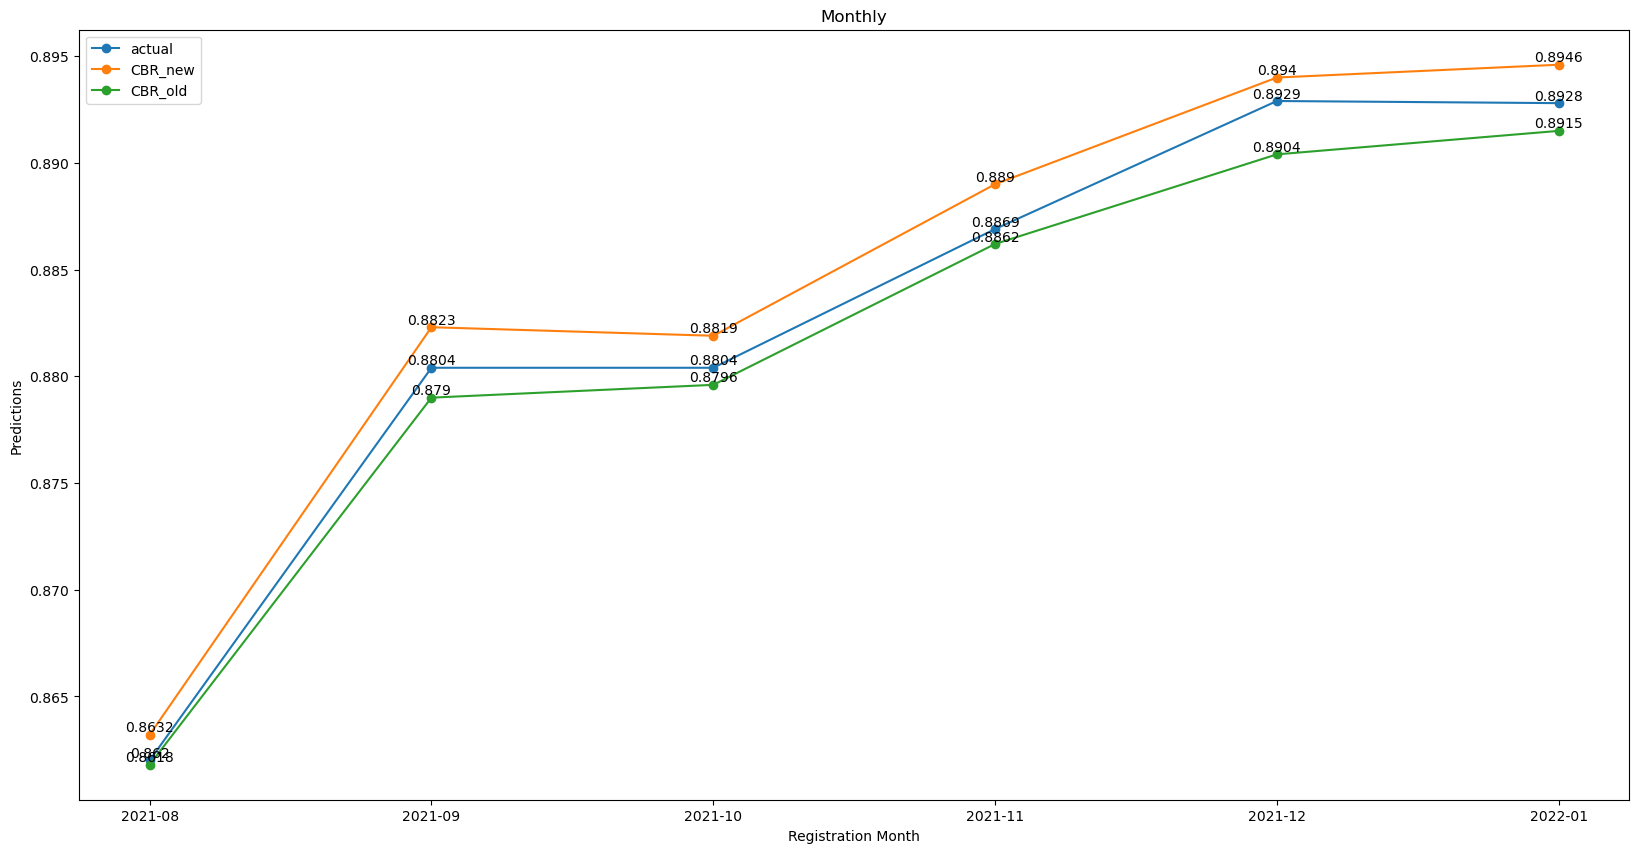

In [37]:
print('Avg error_new:',np.round(np.abs(df_comparison_360['actual']- df_comparison_360['CBR_new']).mean(),4))
print('Avg error_old:',np.round(np.abs(df_comparison_360['actual']- df_comparison_360['CBR_old']).mean(),4))

plot_preds_actuals(df_comparison_360, 'Month',['actual','CBR_new','CBR_old'],
                  'Registration Month', 'Predictions', 'Monthly')

Kenya
Avg error_new: 0.0021
Avg error_old: 0.0023


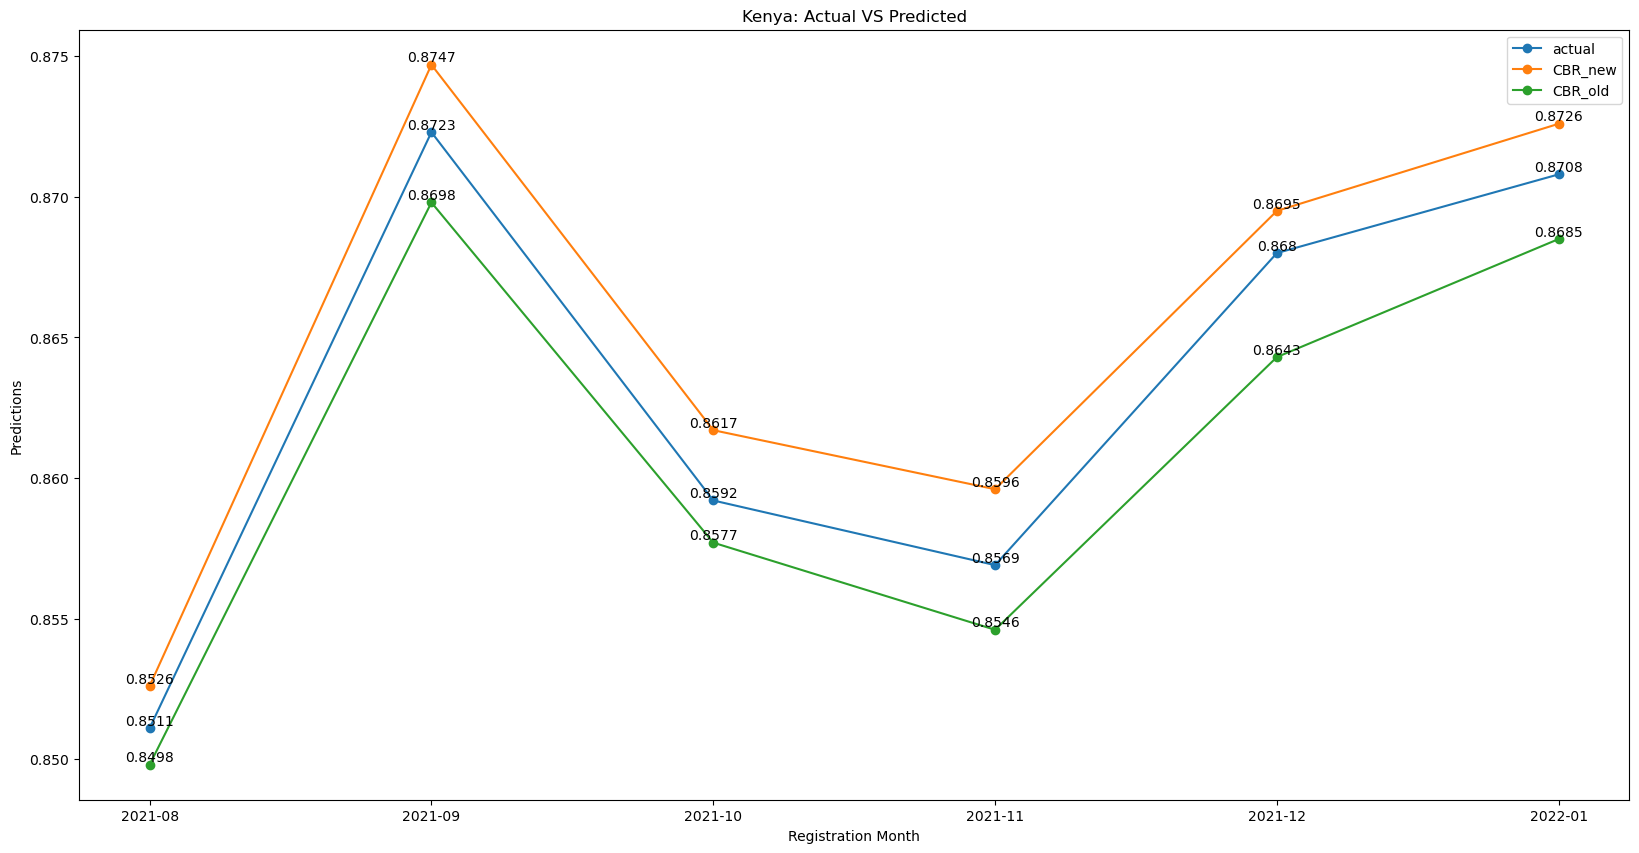

----------------------------------------------------------------------
Nigeria
Avg error_new: 0.0015
Avg error_old: 0.0022


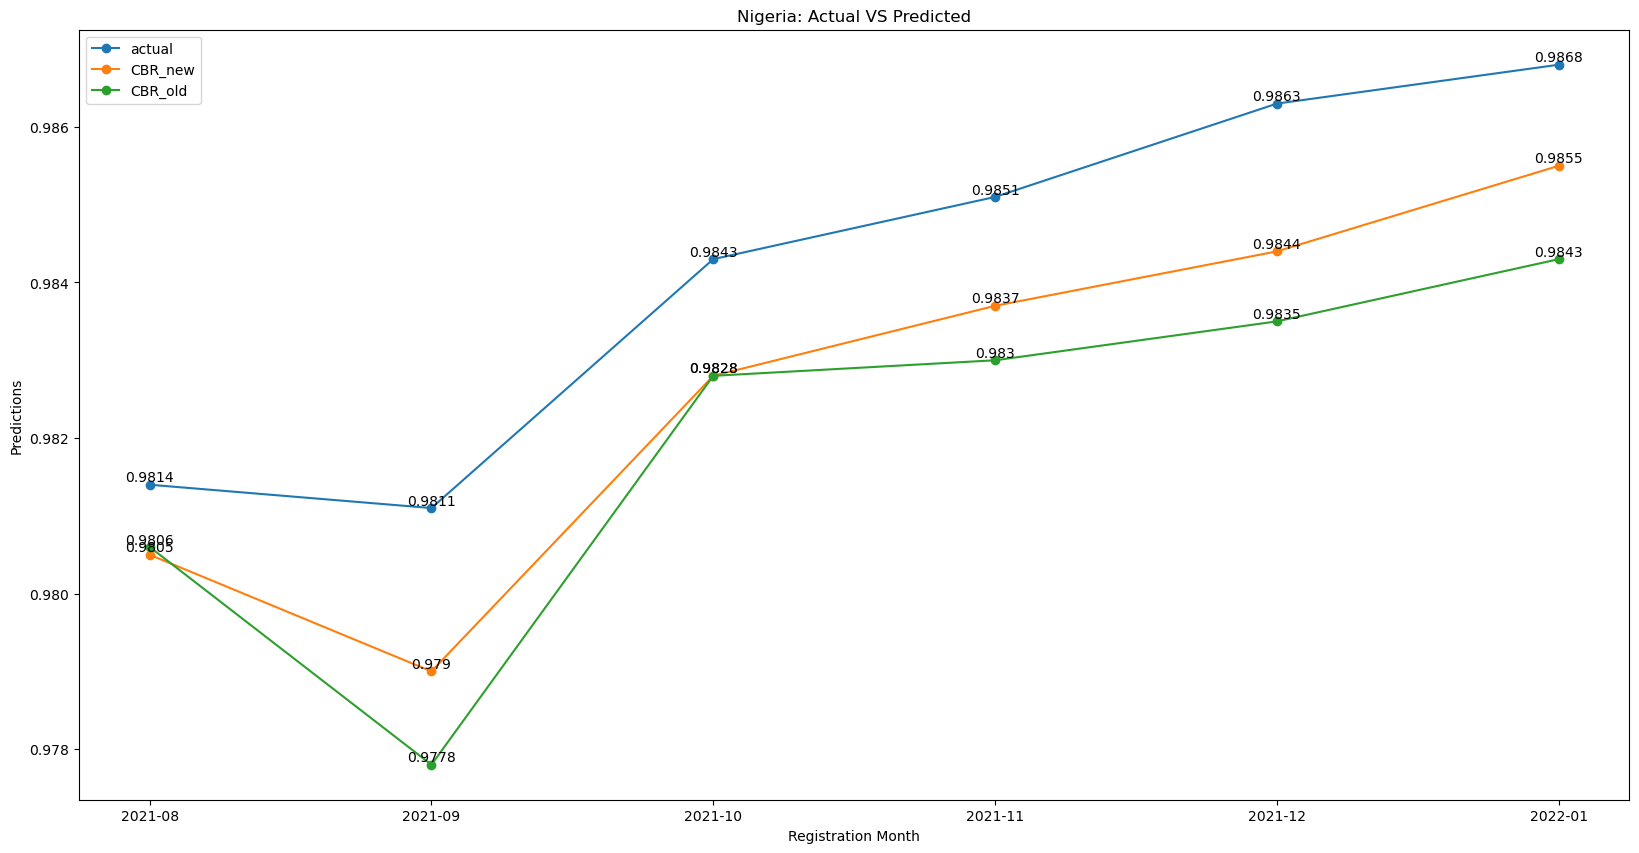

----------------------------------------------------------------------
Tanzania
Avg error_new: 0.006
Avg error_old: 0.0053


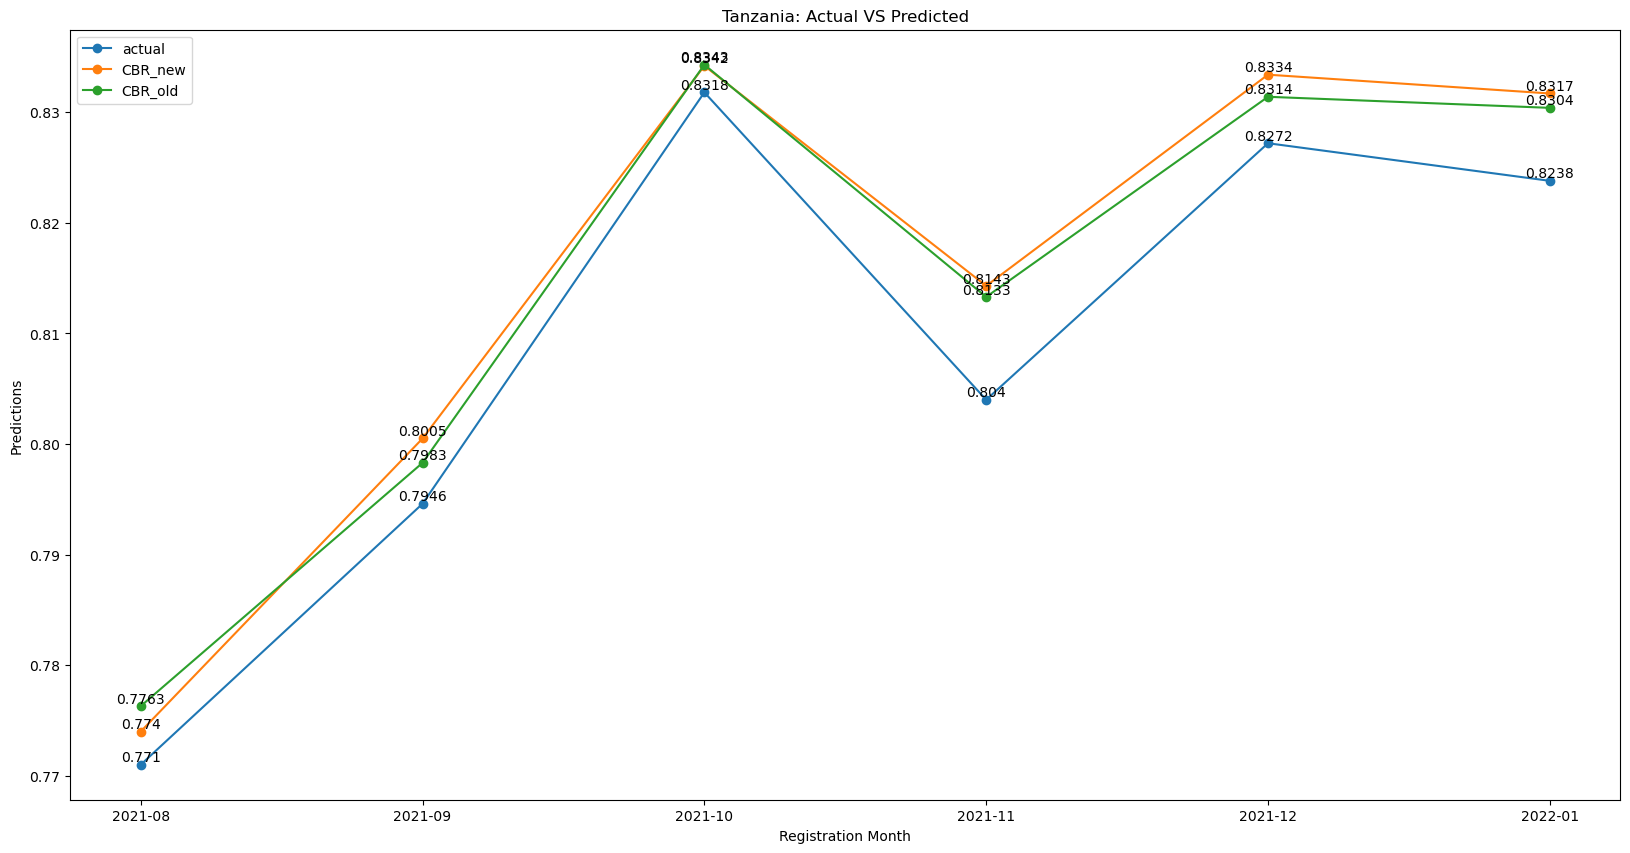

----------------------------------------------------------------------
Uganda
Avg error_new: 0.0058
Avg error_old: 0.0048


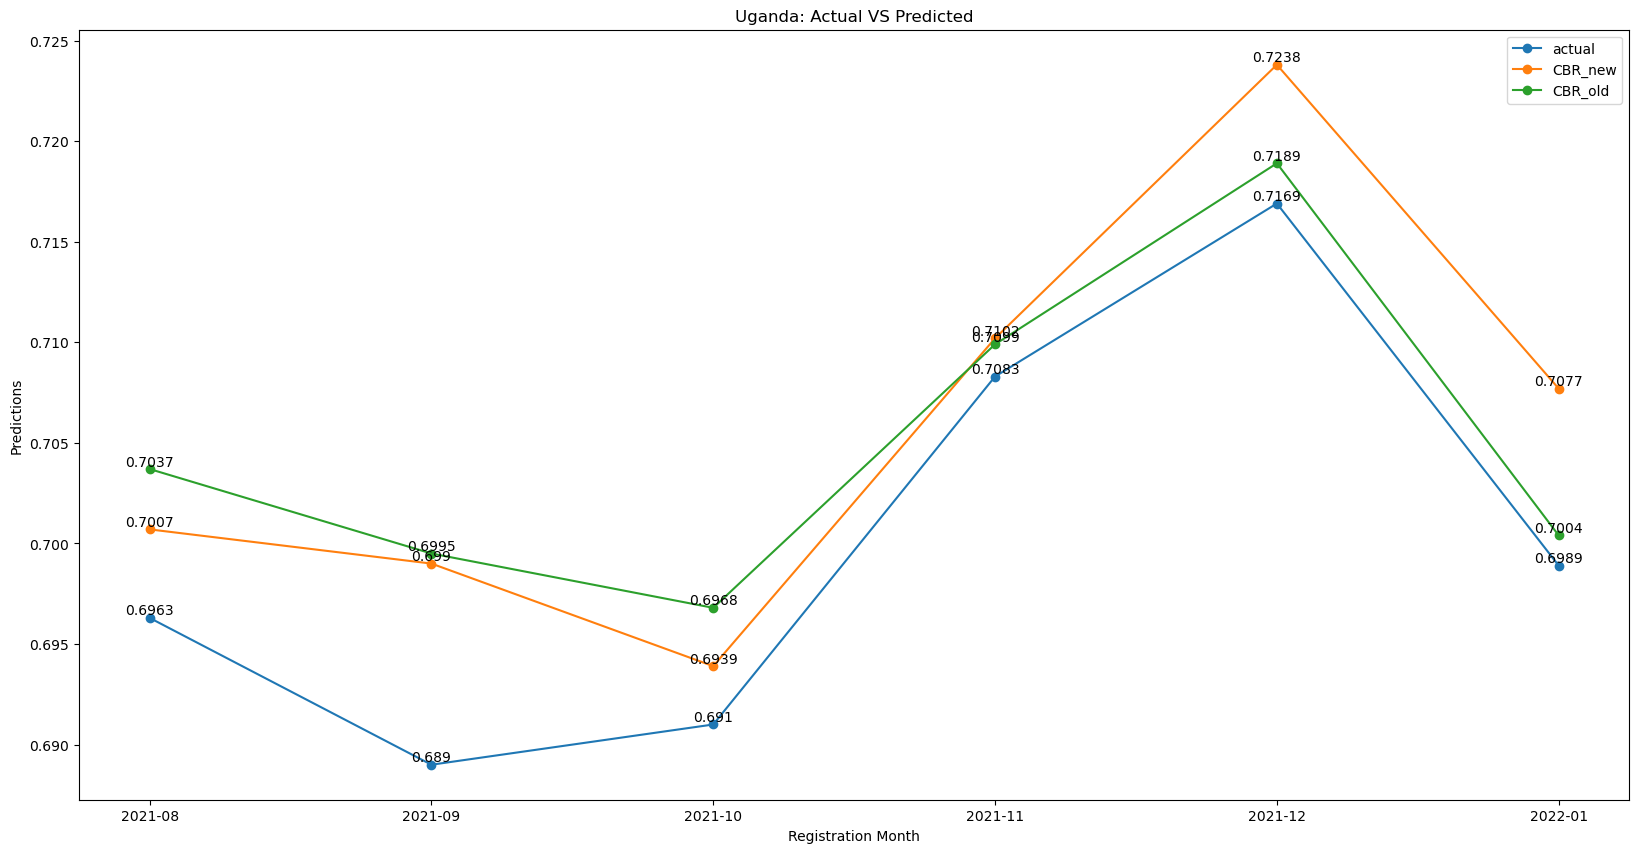

----------------------------------------------------------------------


In [38]:
for country in list_countries:
    print(country)
    df_comparison = dict_comparison_country_wise_360[dict_comparison_country_wise_360['Country']==country].reset_index().drop(columns='index')
    print('Avg error_new:',np.round(np.abs(df_comparison['actual']- df_comparison['CBR_new']).mean(),4))
    print('Avg error_old:',np.round(np.abs(df_comparison['actual']- df_comparison['CBR_old']).mean(),4))
    #print('Avg error in CBR_old:, ',np.round(np.abs(df_comparison['actual']- df_comparison['CBR_old']).mean(),4))
    plot_preds_actuals(df_comparison, 'Month',['actual','CBR_new','CBR_old'],
                   'Registration Month','Predictions',country+': Actual VS Predicted')
    
    print('----------------------------------------------------------------------')

Kenya
Lanterns
Avg error_new: 0.001
Avg error_old: 0.0034


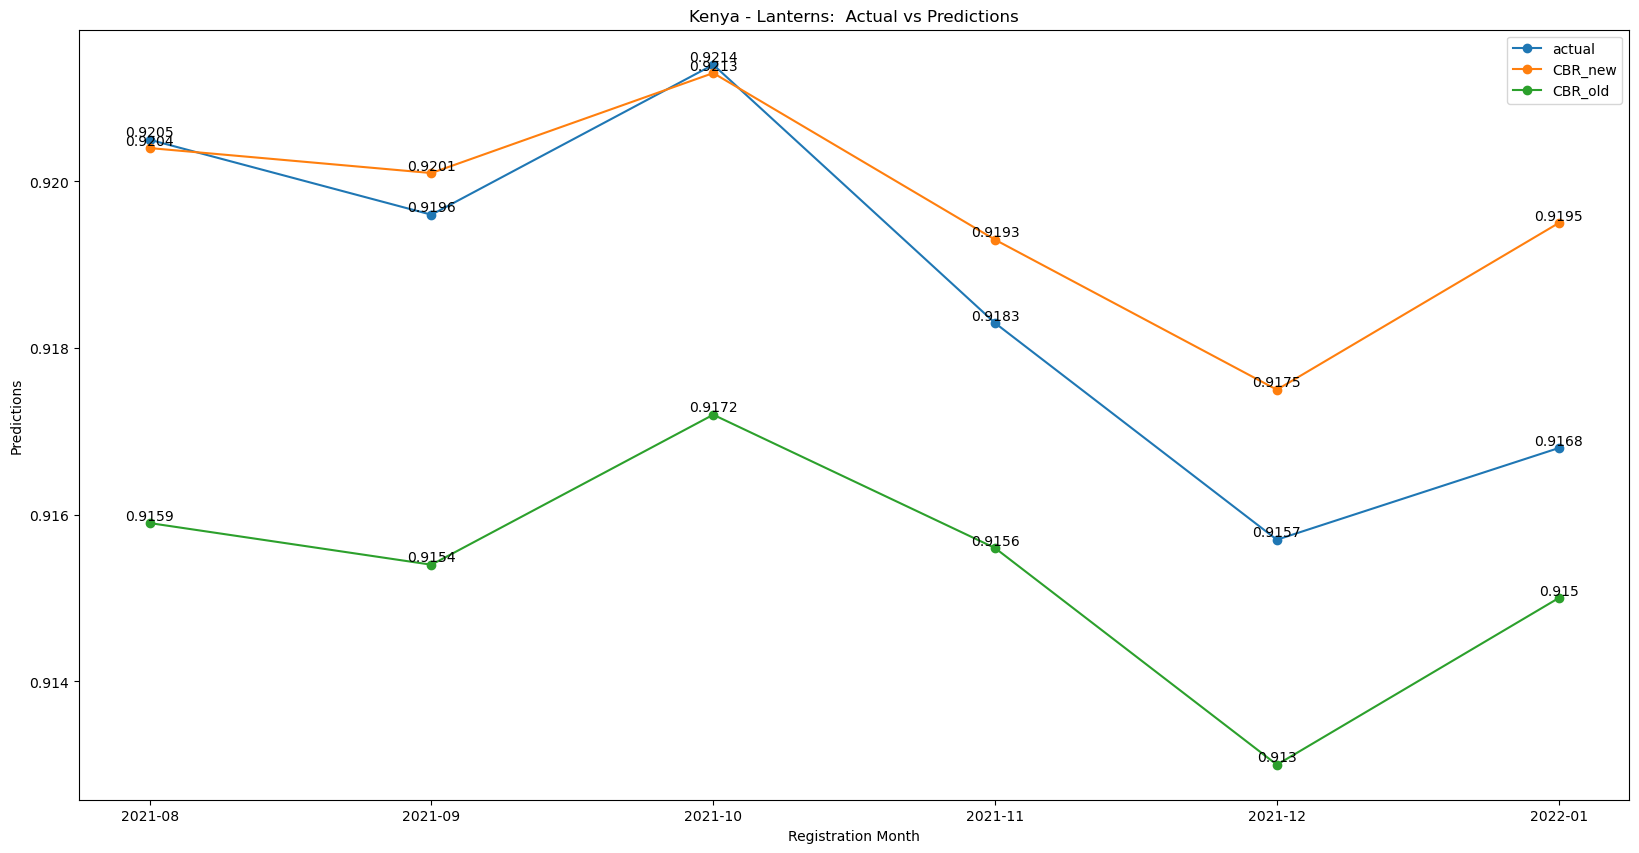

SHS with TV
Avg error_new: 0.0073
Avg error_old: 0.0064


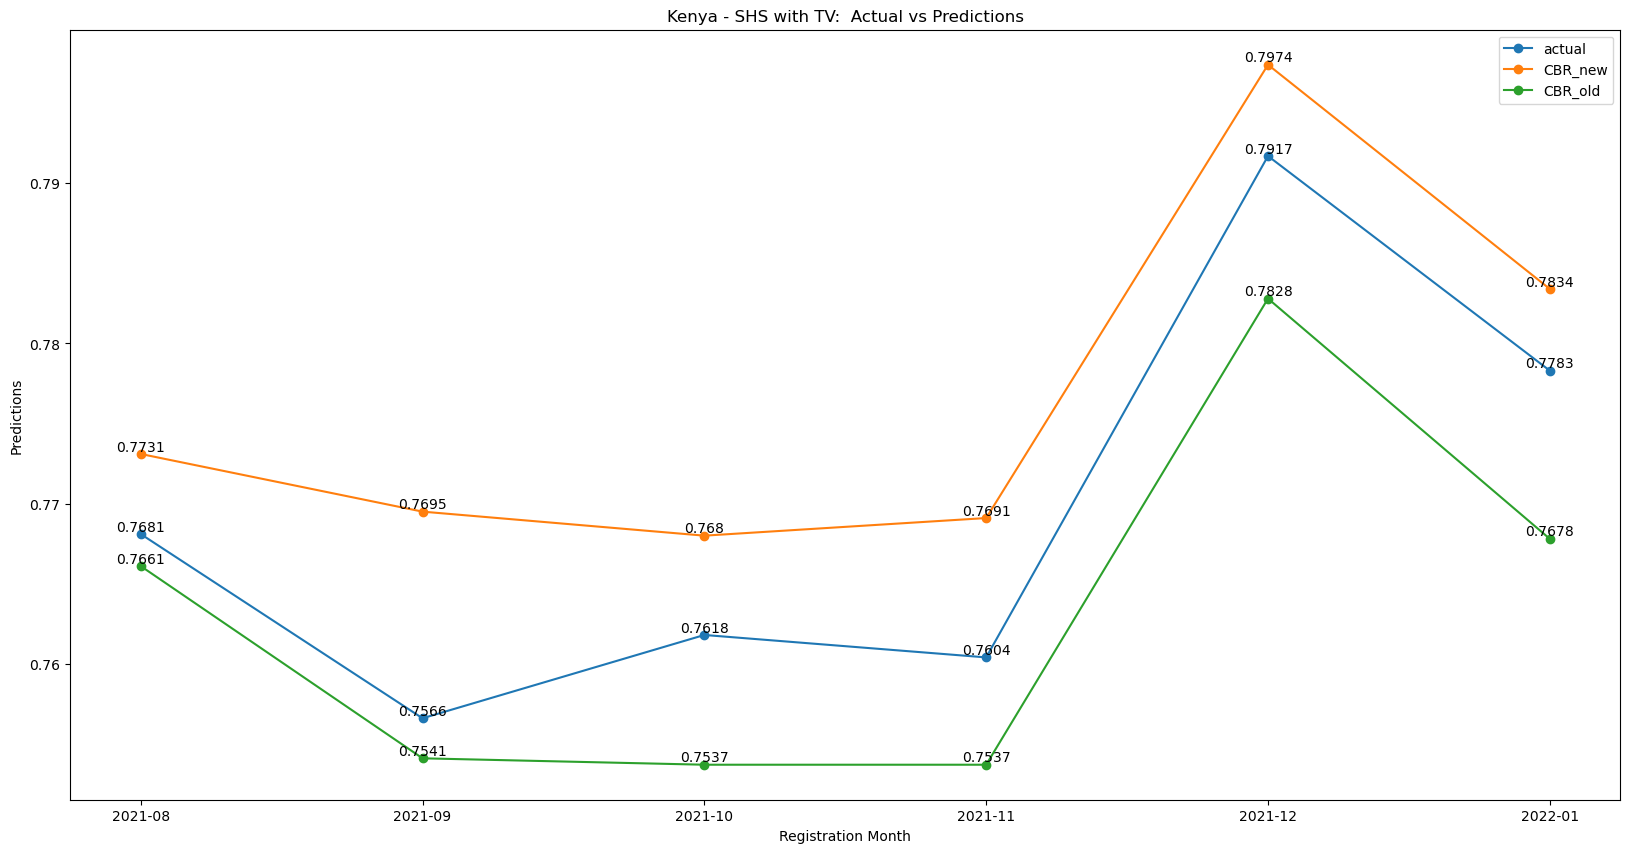

SHS without TV
Avg error_new: 0.0176
Avg error_old: 0.0129


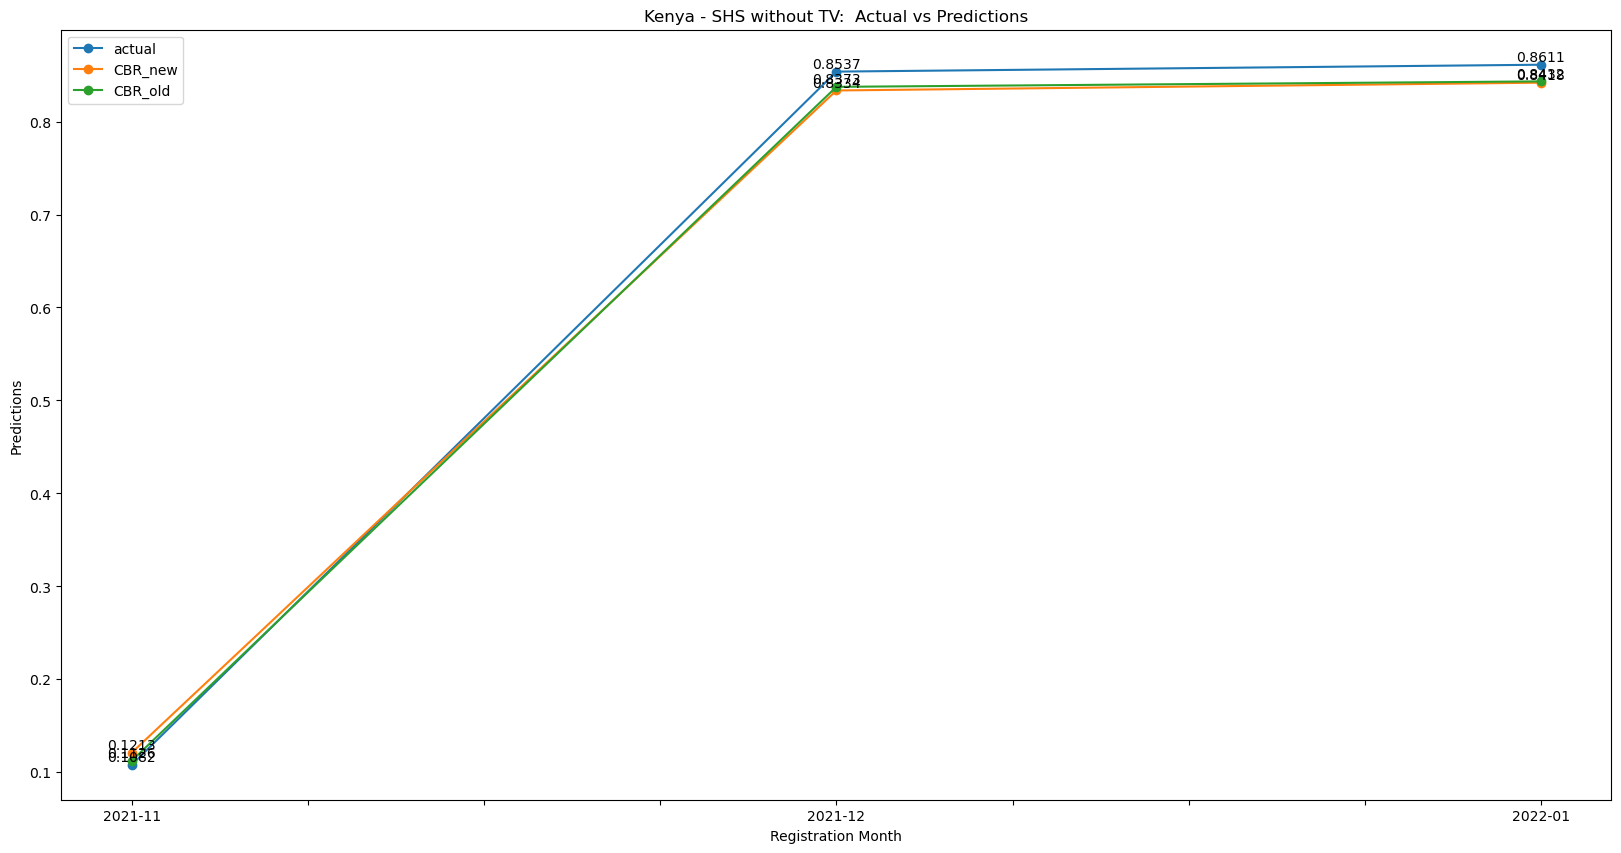

SHS Entry-Level
Avg error_new: 0.0013
Avg error_old: 0.0012


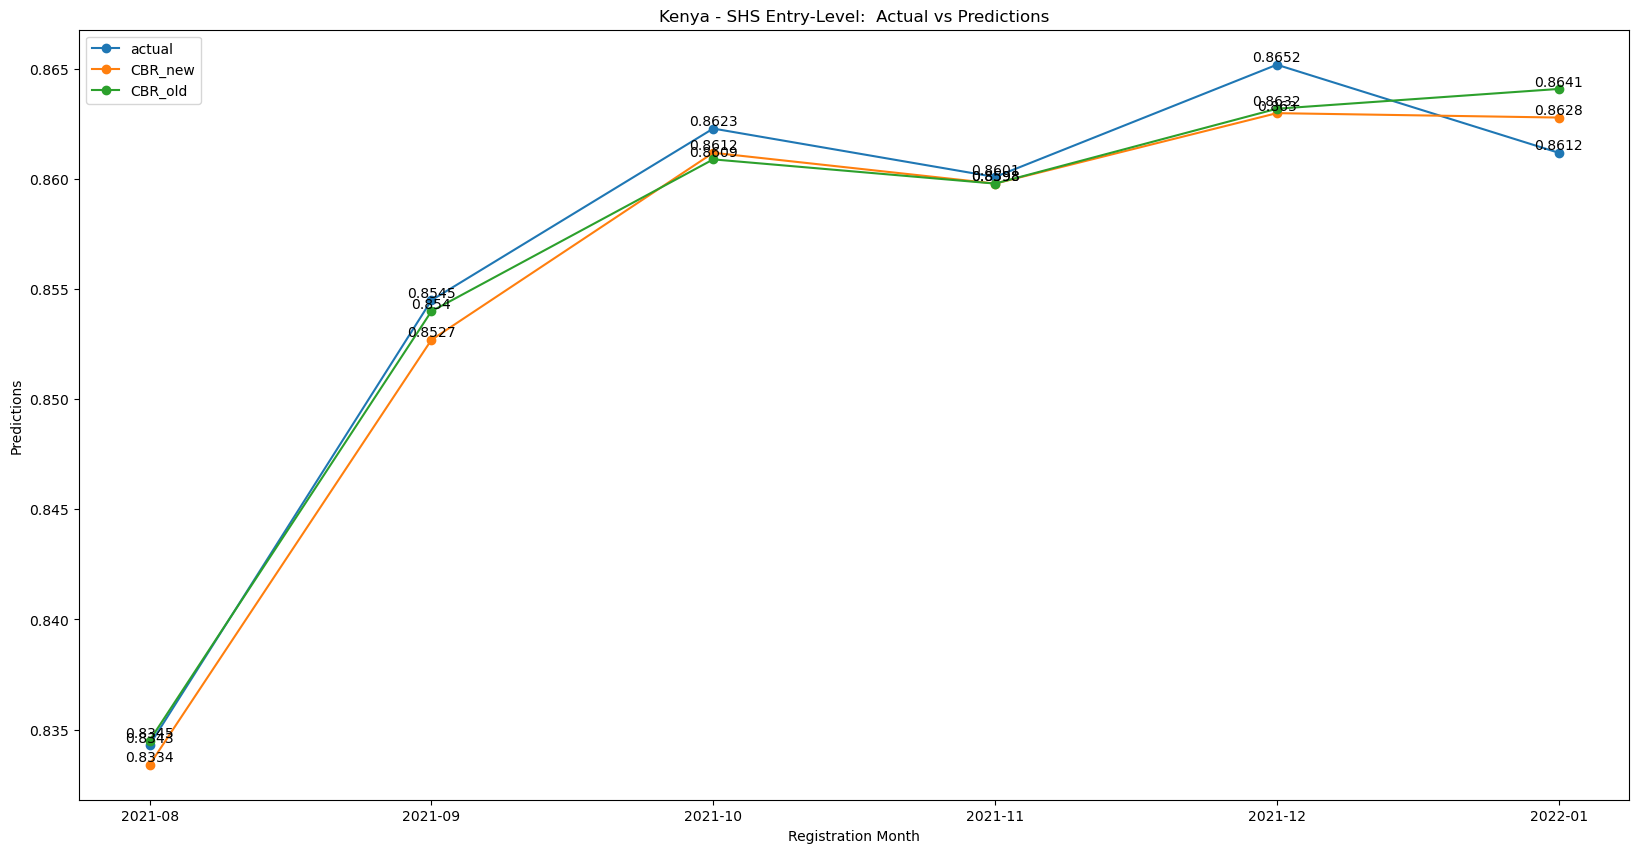

----------------------------------------------------------------------
Nigeria
Lanterns
Avg error_new: nan
Avg error_old: nan
SHS with TV
Avg error_new: 0.0039
Avg error_old: 0.0069


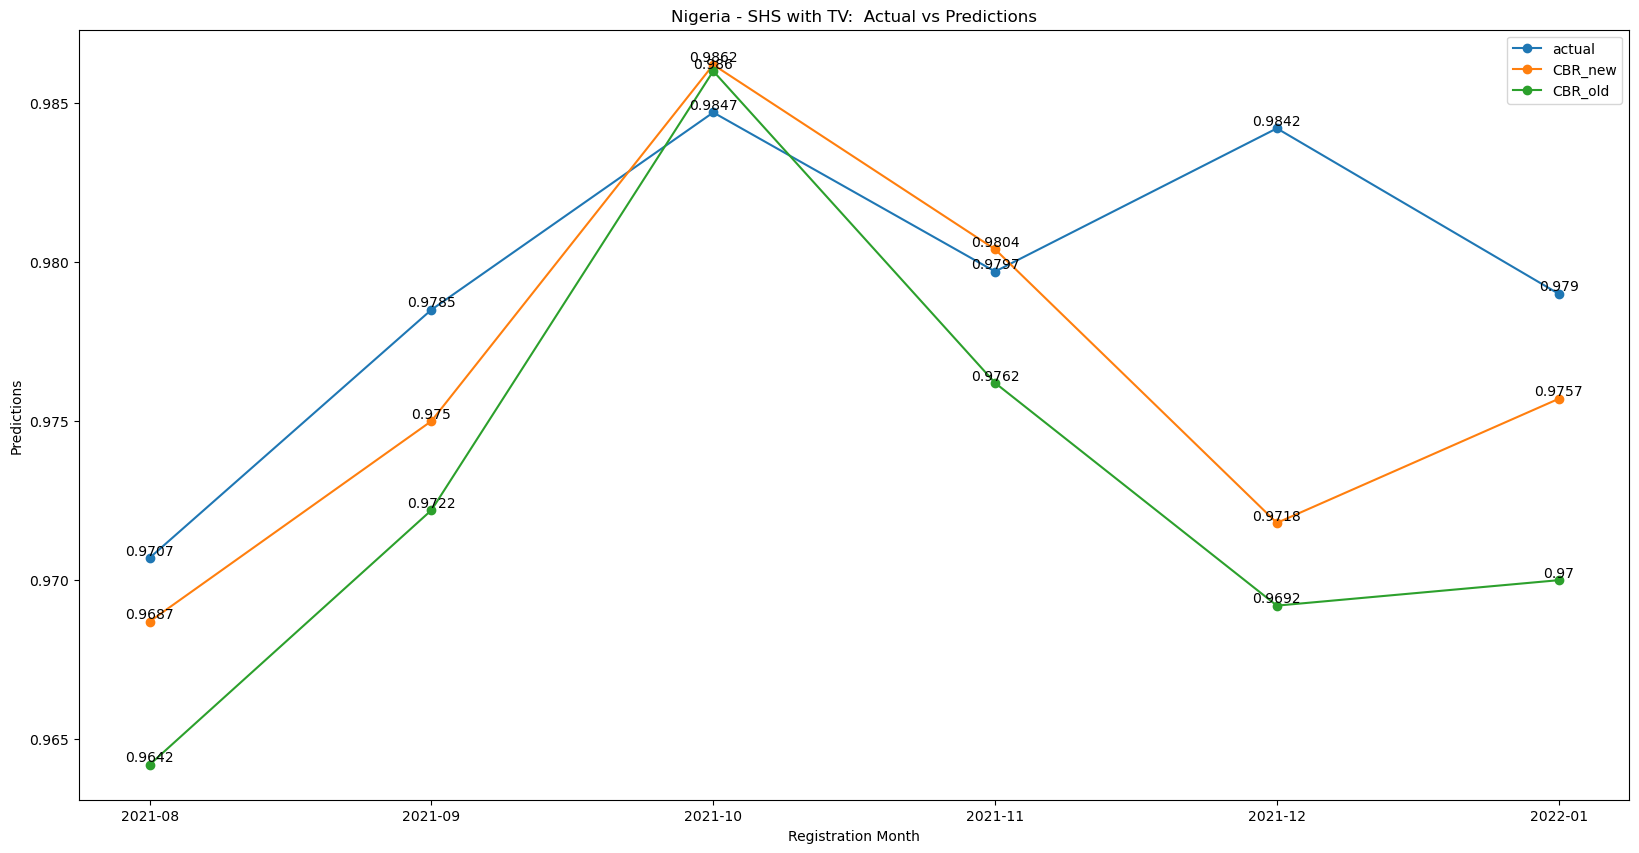

SHS without TV
Avg error_new: 0.0009
Avg error_old: 0.0022


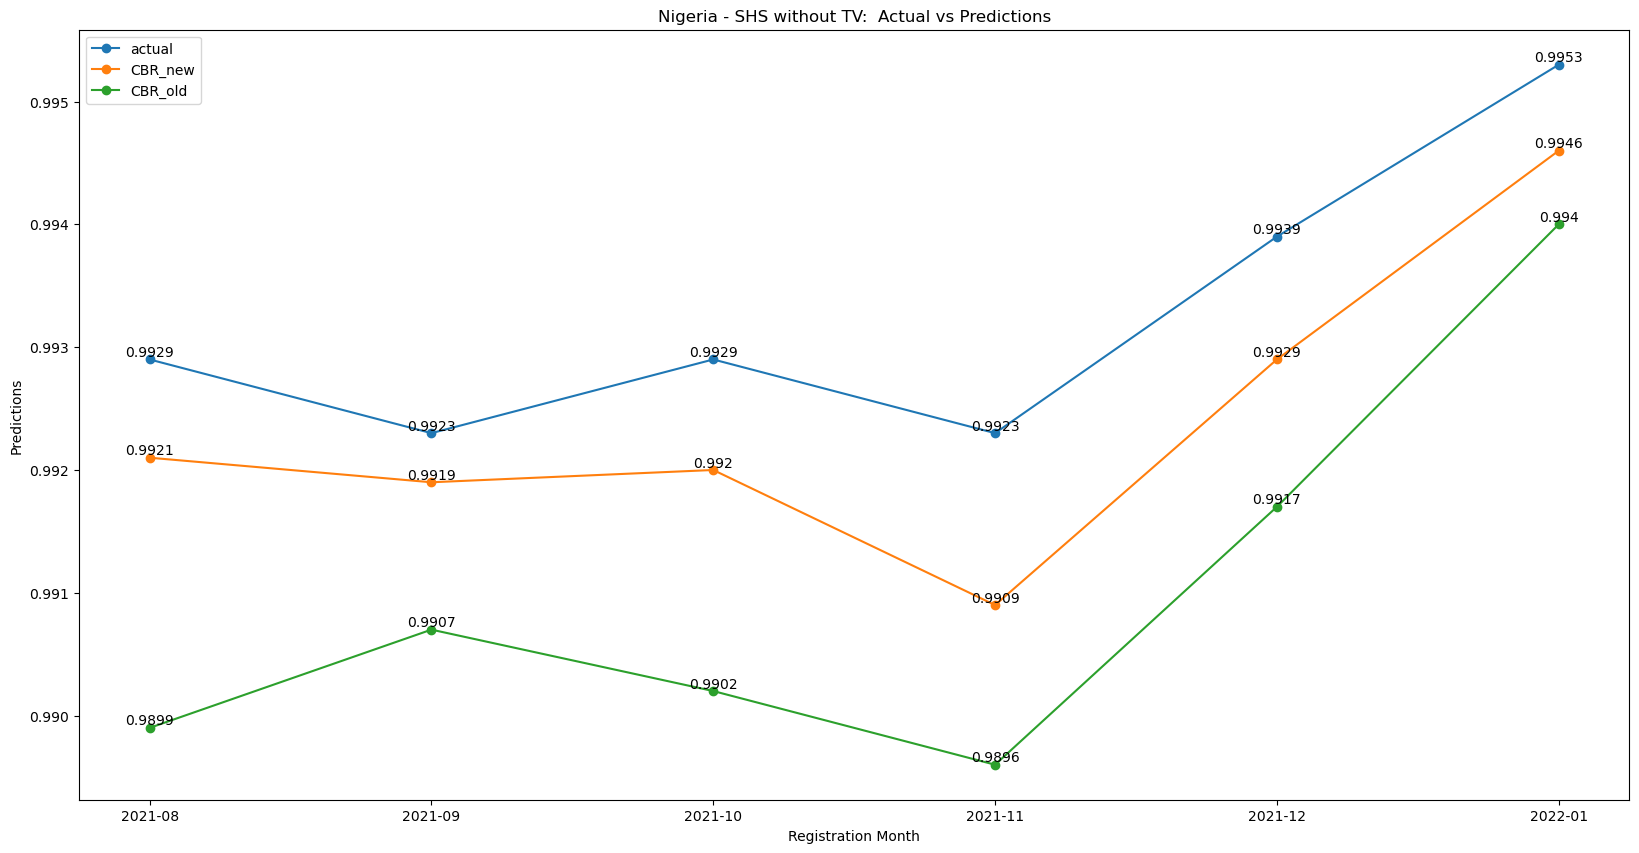

SHS Entry-Level
Avg error_new: 0.0005
Avg error_old: 0.0008


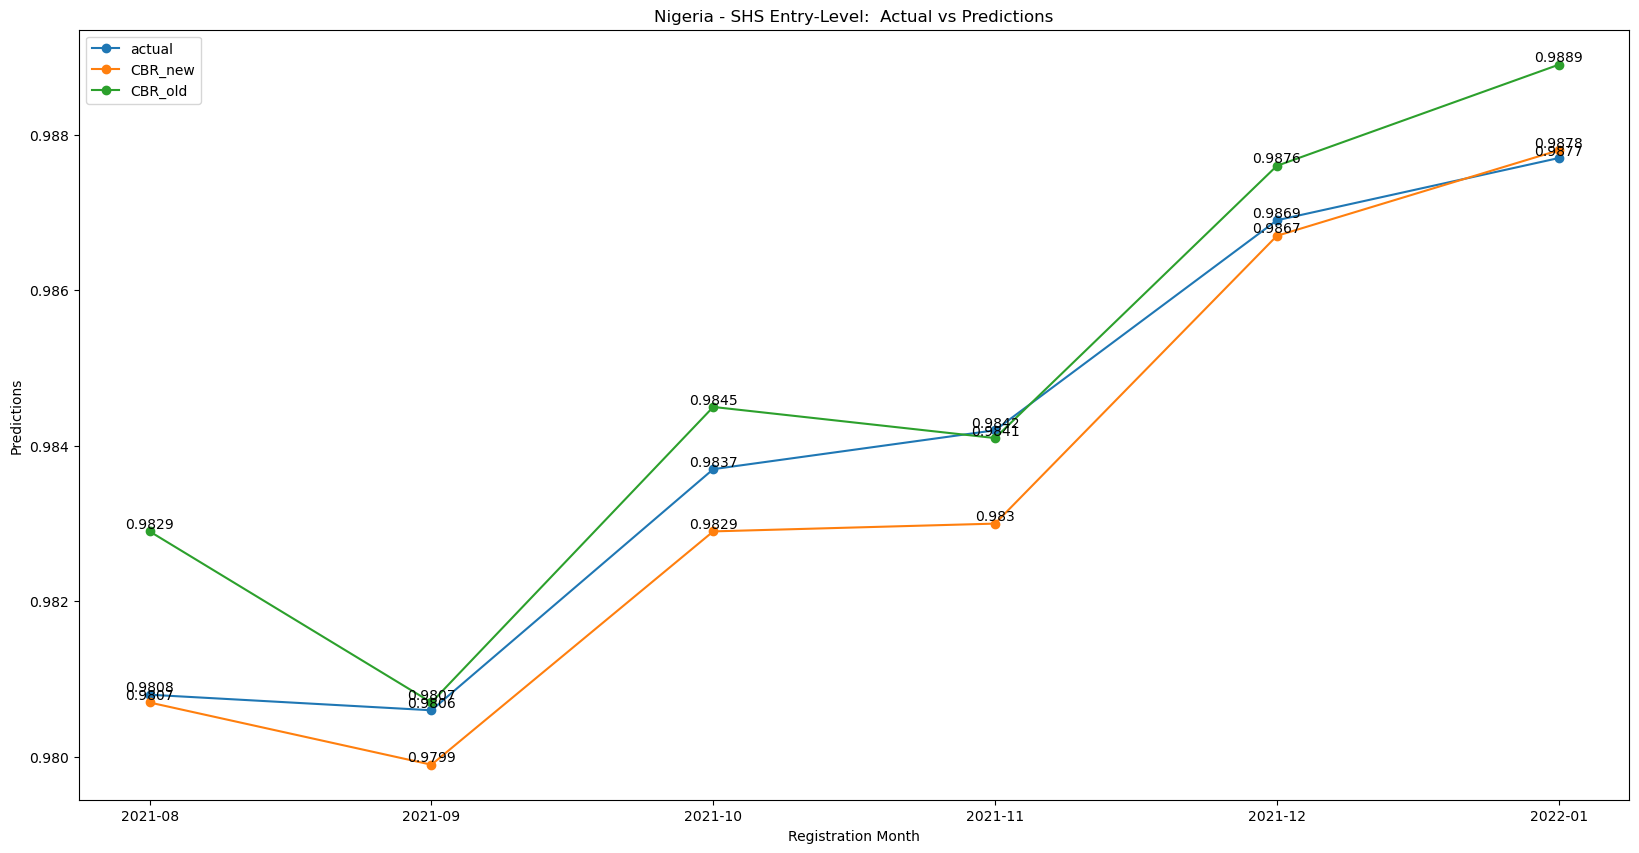

----------------------------------------------------------------------
Tanzania
Lanterns
Avg error_new: 0.0078
Avg error_old: 0.0069


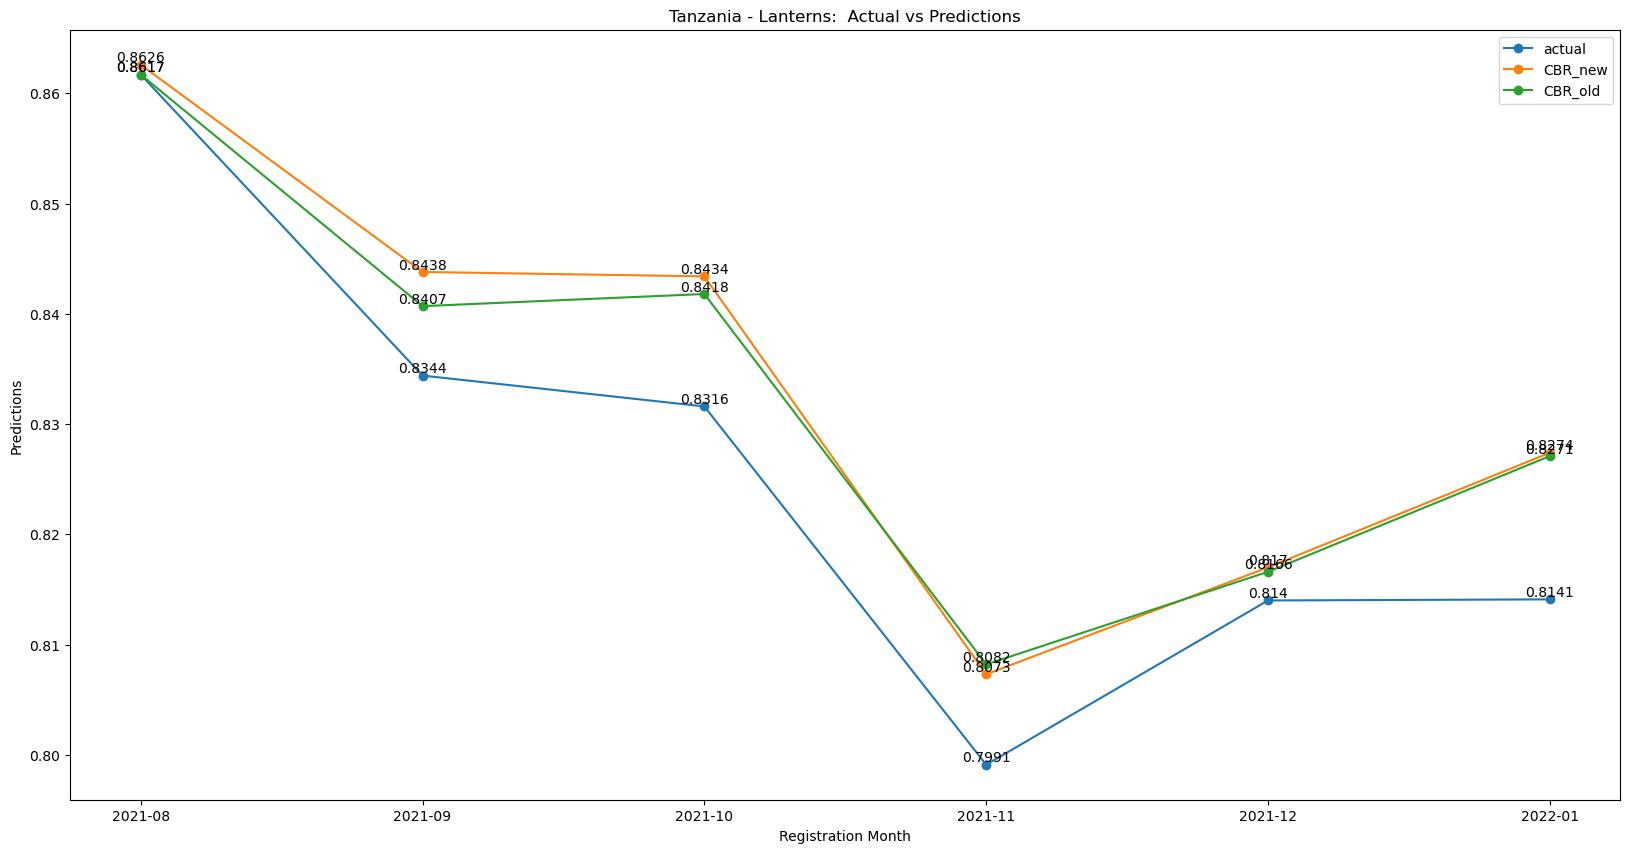

SHS with TV
Avg error_new: 0.0141
Avg error_old: 0.012


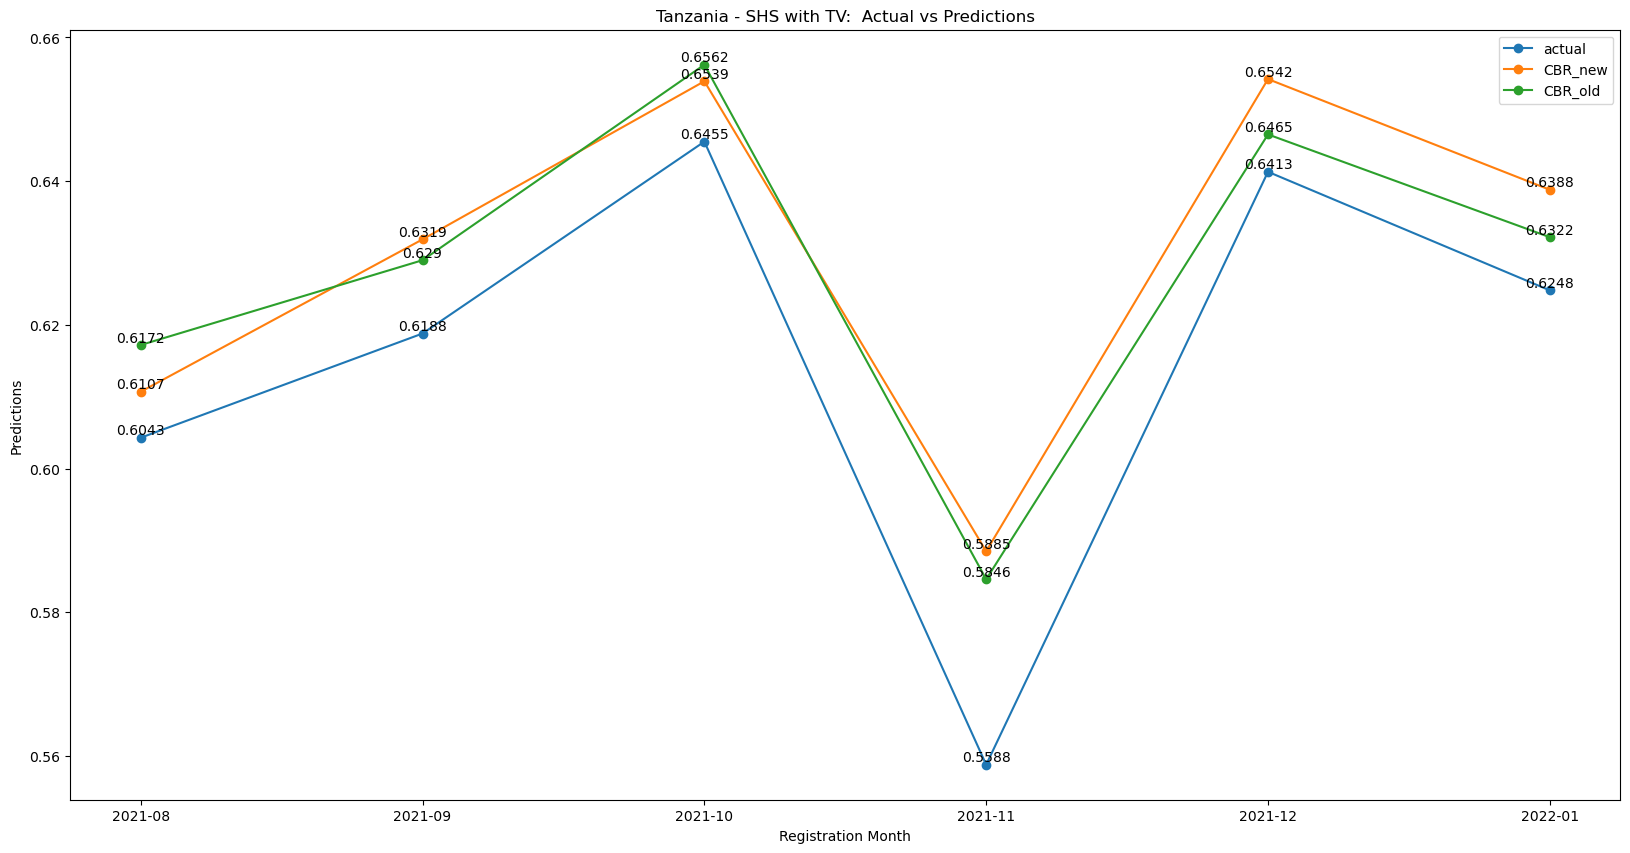

SHS without TV
Avg error_new: nan
Avg error_old: nan
SHS Entry-Level
Avg error_new: 0.0028
Avg error_old: 0.0026


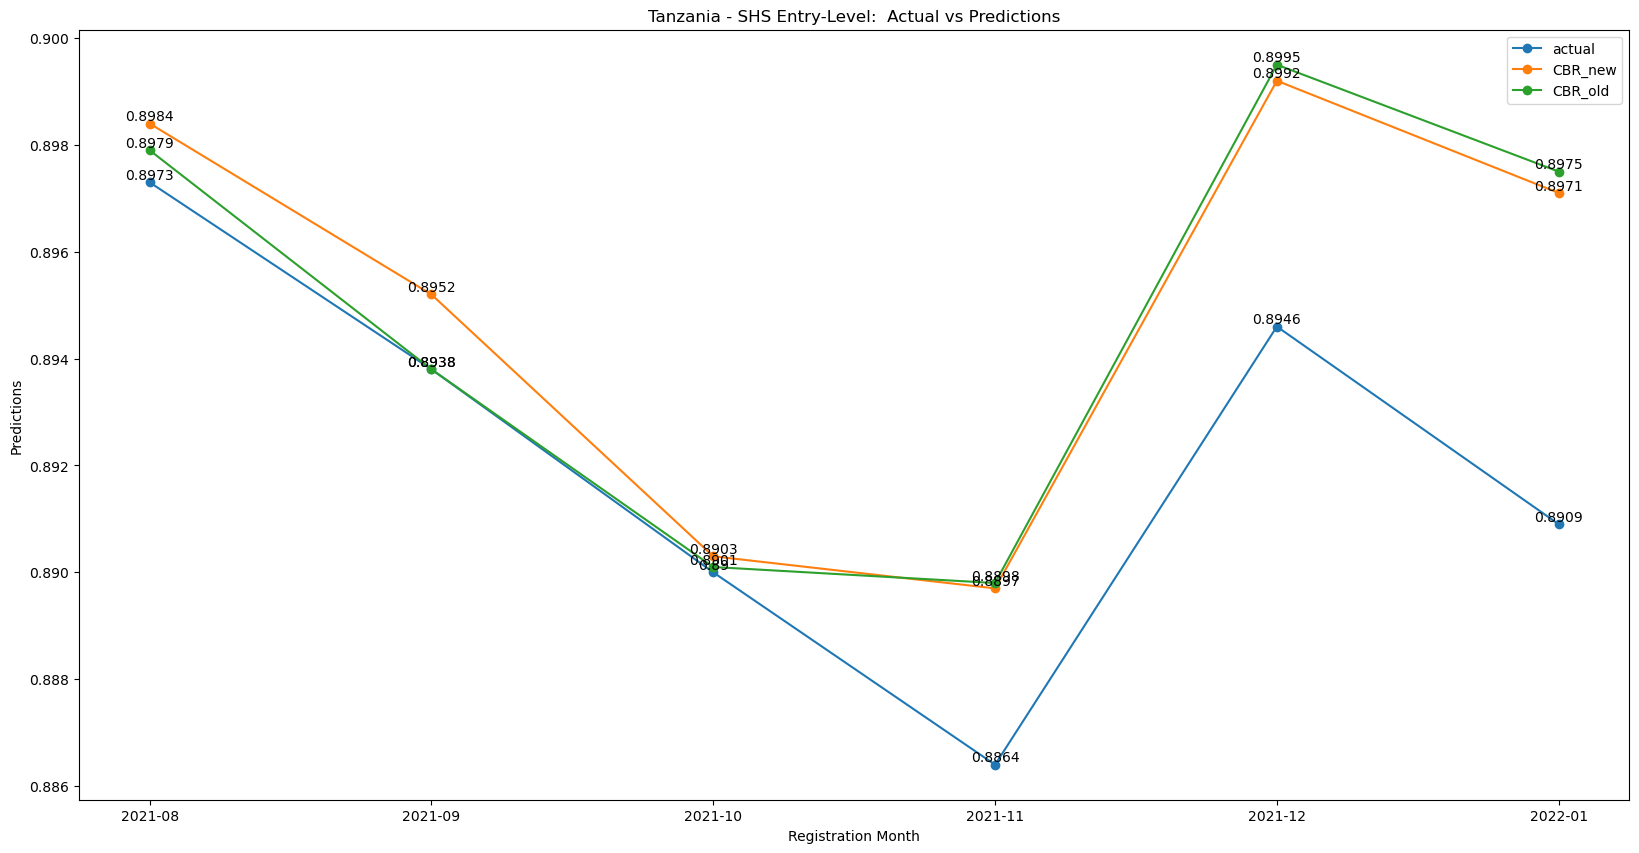

----------------------------------------------------------------------
Uganda
Lanterns
Avg error_new: 0.0043
Avg error_old: 0.0037


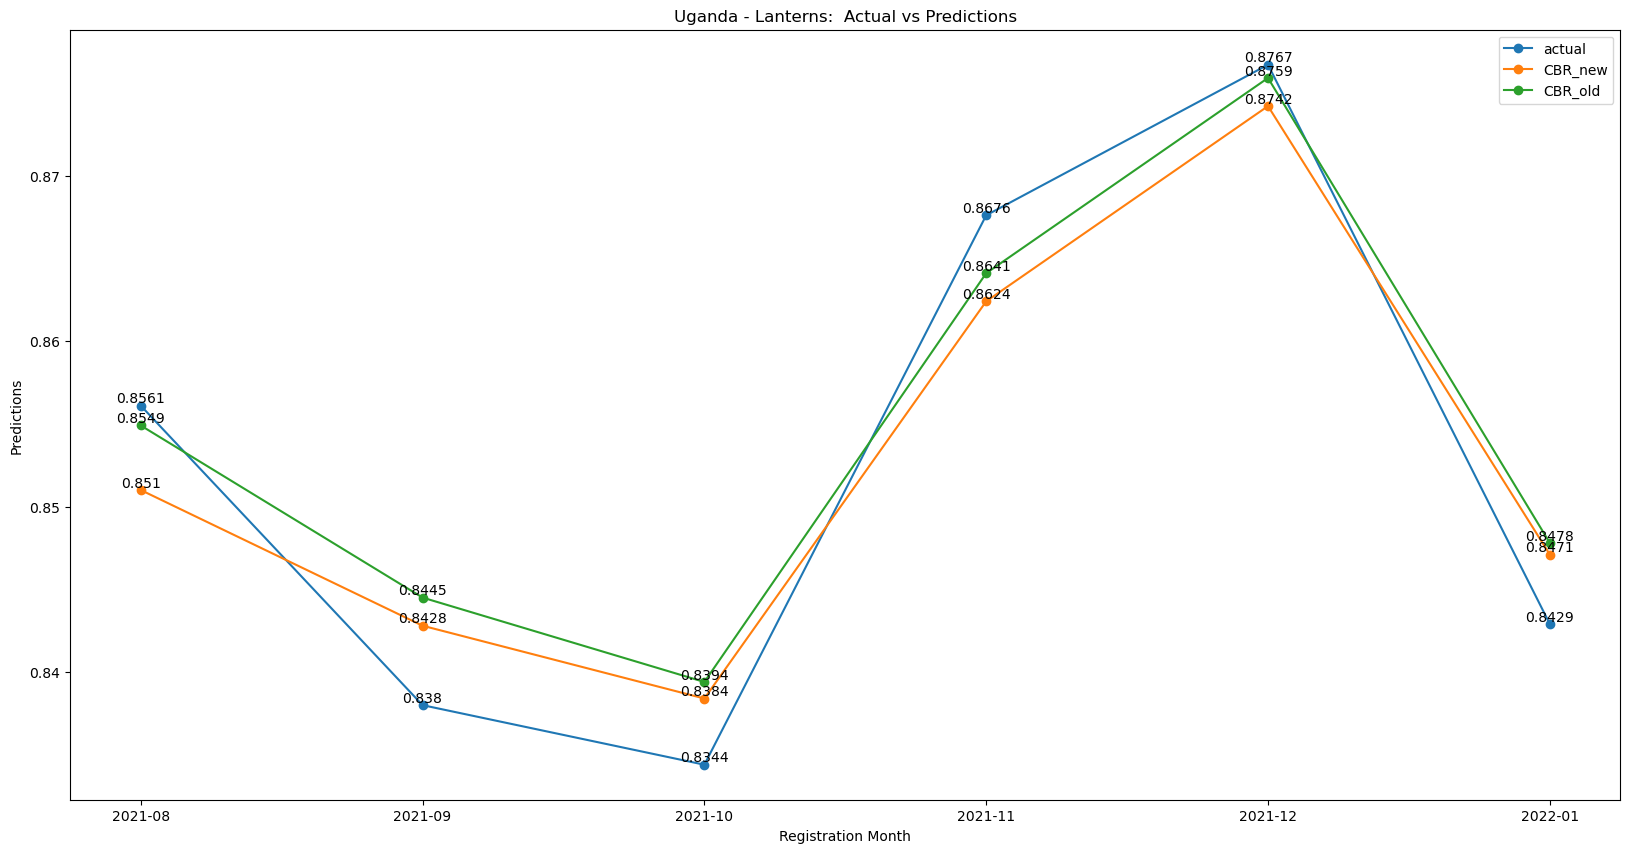

SHS with TV
Avg error_new: 0.0192
Avg error_old: 0.0215


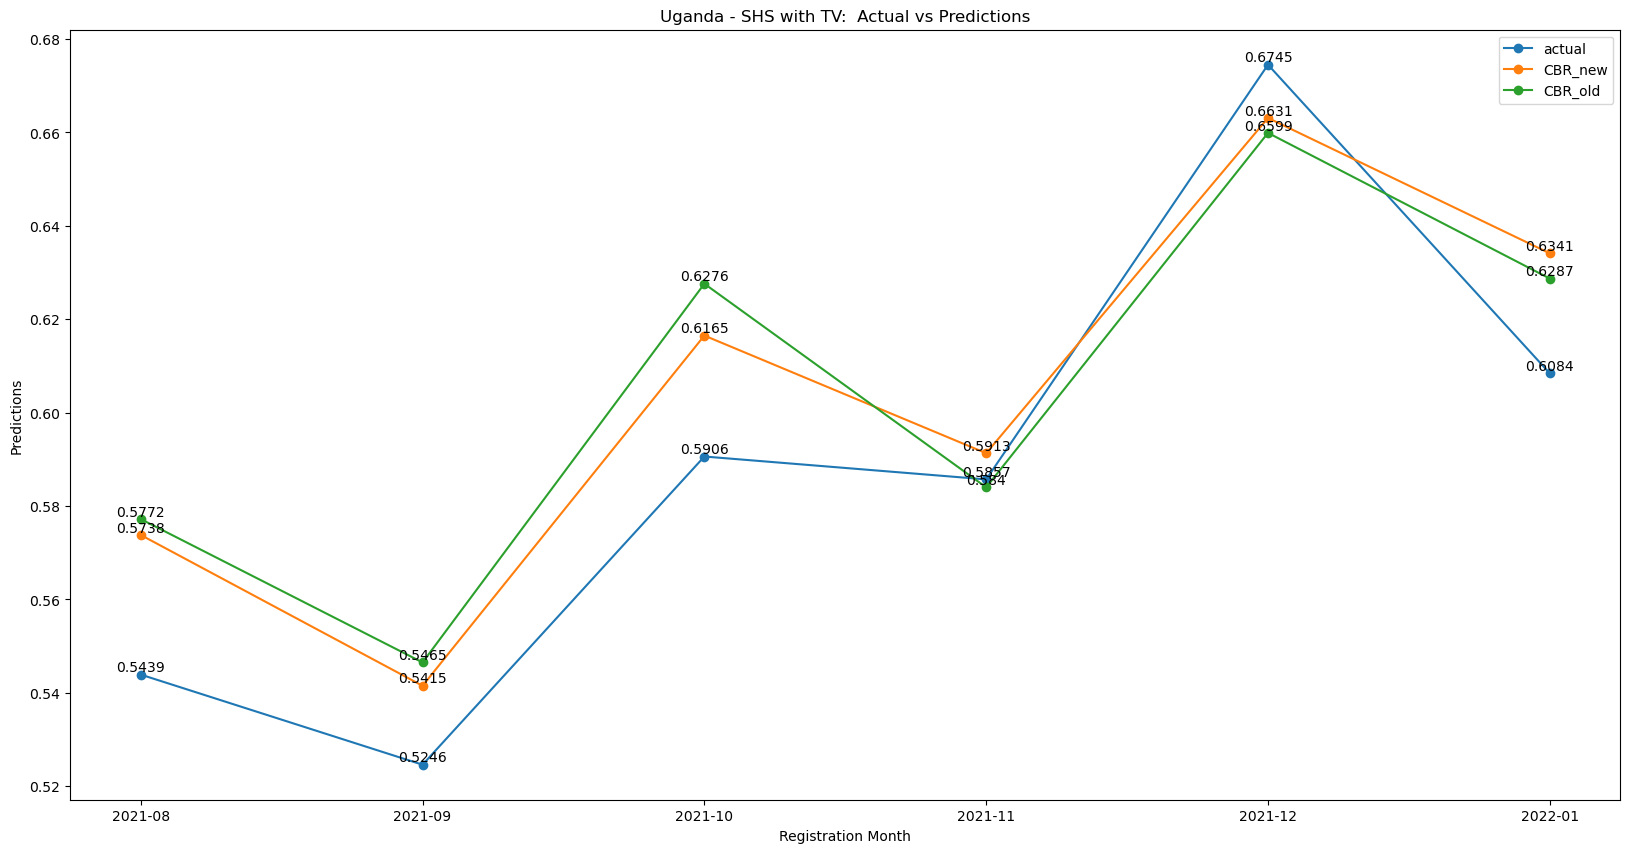

SHS without TV
Avg error_new: nan
Avg error_old: nan
SHS Entry-Level
Avg error_new: 0.0054
Avg error_old: 0.0046


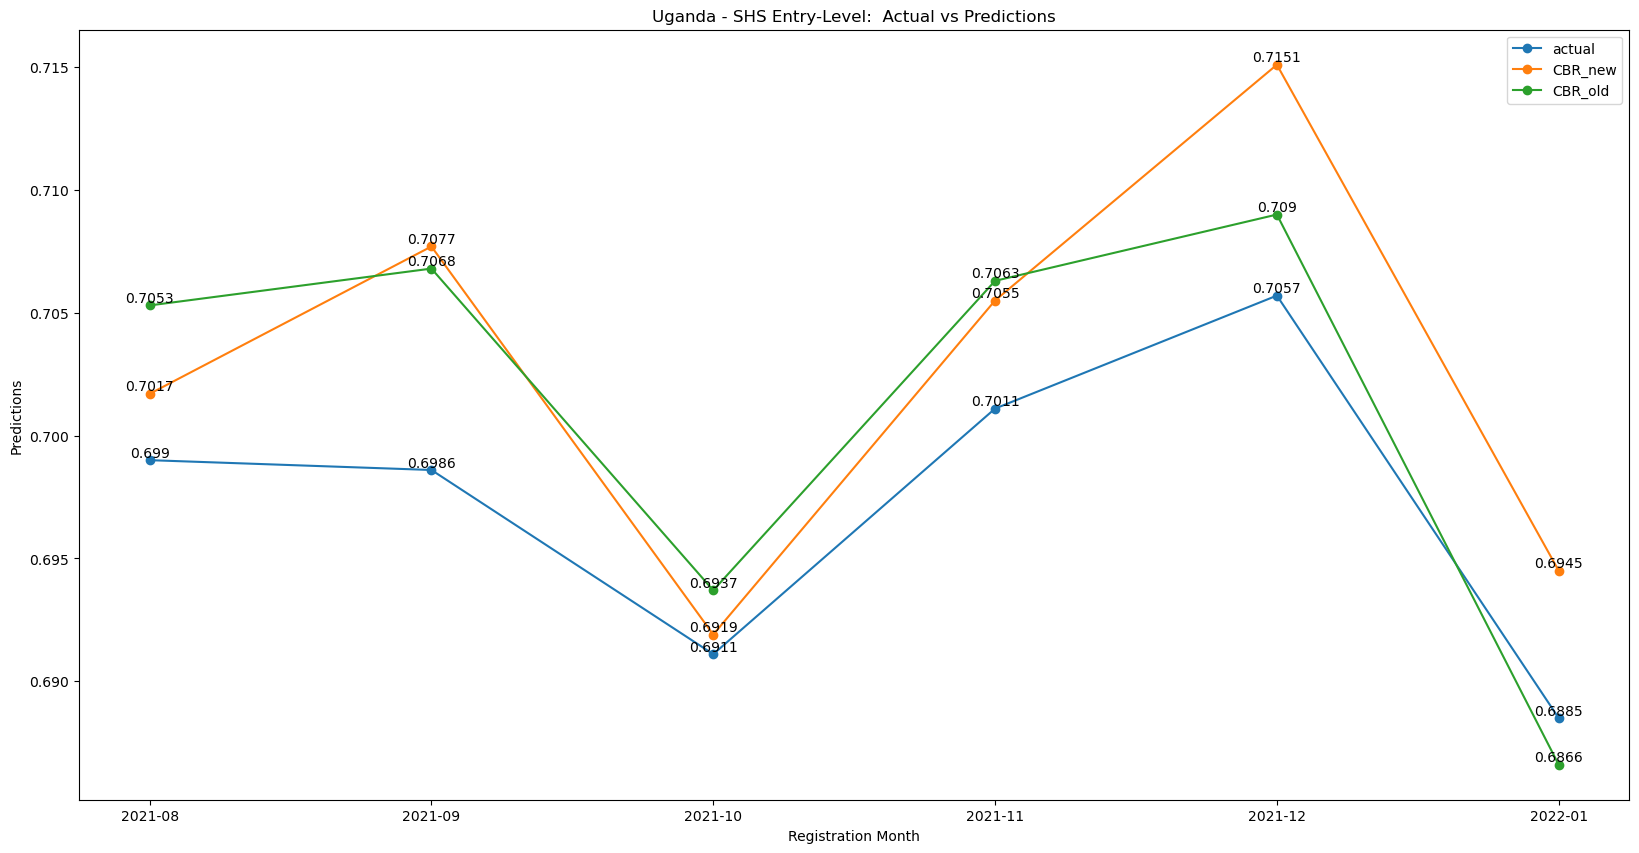

----------------------------------------------------------------------


In [39]:
for country in list_countries:
    
    print(country)    
    for product in product_list:
        
        print(product) 
        df_product_comparison = dict_comparison_product_wise_360[(dict_comparison_product_wise_360['Country']==country) & (dict_comparison_product_wise_360['Product']==product)]
        print('Avg error_new:',np.round(np.abs(df_product_comparison['actual']- df_product_comparison['CBR_new']).mean(),4))
        print('Avg error_old:',np.round(np.abs(df_product_comparison['actual']- df_product_comparison['CBR_old']).mean(),4))
        df_product_comparison.reset_index(inplace=True)
        
        plot_preds_actuals(df_product_comparison, 'Month',['actual','CBR_new','CBR_old'],
                       'Registration Month','Predictions',country+' - '+product+':  Actual vs Predictions')
    
    print('----------------------------------------------------------------------')